# Final Project

Author: Kohsheen Tiku

Email: kt2761@nyu.edu

NETID: N11000167

### OBJECTIVE: To predict next period **price returns** of a stock given its past prices using Neural NetworKS.

- Given the historical prices of a stock, the task is to predict the next period price returns. Since we are predicting a continuous value (price return), this is a **regression task.**
- The performance metric for this regression task can be the Mean Squared Error (MSE) or the Root Mean Squared Error (RMSE), which give an estimate of the average squared difference between the predicted and actual values. RMSE is preferred as it is in the same unit as the target variable and is easier to interpret.


- Exploratory Data Analysis
- Feature Engineering
- Creating, testing and evaluating models
- Error analysis
and Prediction **using Neural Networks**.

In [227]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import math as math

# 1. Exploratory Data Analysis


In [228]:
# Observe the data 
train_AAPL = pd.read_csv('./Data/train/AAPL.csv')
train_AAPL['Target_Returns'] = train_AAPL['Close'].pct_change()
train_AAPL= train_AAPL.dropna()
train_AAPL.head()

Dt  Adj Close   Close  Div  Factor     High      Low      Open   
1  2000-01-04     3.1852  102.50  0.0     1.0  110.625  101.188  108.2500  \
2  2000-01-05     3.2318  104.00  0.0     1.0  110.563  103.000  103.7500   
3  2000-01-06     2.9521   95.00  0.0     1.0  107.000   95.000  106.1183   
4  2000-01-07     3.0920   99.50  0.0     1.0  101.000   95.500   96.5000   
5  2000-01-10     3.0376   97.75  0.0     1.0  102.250   94.750  102.0000   

        Volume  Target_Returns  
1  128094400.0       -0.084315  
2  194580400.0        0.014634  
3  191993200.0       -0.086538  
4  115183600.0        0.047368  
5  126266000.0       -0.017588

Here's a description of each column:

- Dt: Date of the observation
- Adj Close: Adjusted closing price of the stock
- Close: Closing price of the stock
- Div: Dividend paid by the company on the corresponding date (if any)
- Factor: Stock split factor on the corresponding date (if any)
- High: Highest price of the stock on the corresponding date
- Low: Lowest price of the stock on the corresponding date
- Open: Opening price of the stock on the corresponding date
- Volume: Volume of shares traded on the corresponding date
- Target_Returns: Target returns for the stock on the next trading day

To be more precise, the **Div** column in a stock market dataset contains information about the dividends paid out by the company. Dividends are payments made by a company to its shareholders from its profits or reserves. The amount of the dividend per share is usually reported in this column. In other words, if you own shares of a company that pays out dividends and the company declares a dividend of $0.50 per share, you would receive $0.50 for each share you own.

The **Factor** column in a stock market dataset contains information about stock splits and other corporate actions that affect the number of outstanding shares of the company. A stock split occurs when a company increases the number of its outstanding shares by issuing new shares to its existing shareholders. This is usually done in order to make the shares more affordable for investors, and to increase liquidity in the market.

For example, if a company has 100 shares outstanding, and it decides to do a 2-for-1 stock split, it will issue 100 more shares to its existing shareholders, so that there are now 200 shares outstanding. However, the price of the shares will be adjusted so that the total value of the shares remains the same. If the original shares were worth $100 each, after the stock split, the new shares would be worth $50 each.

The factor column typically contains a scaling factor that is used to adjust the historical prices and volumes to reflect the new number of shares outstanding after a stock split or other corporate action. In the case of a 2-for-1 stock split, the factor column would contain a value of 0.5 for all the rows corresponding to dates before the split, and a value of 1.0 for all the rows corresponding to dates after the split. This is because the number of shares outstanding has doubled, so the historical prices and volumes need to be adjusted accordingly.




In [229]:
ticker_list = ['AAPL', 'ACN', 'ADBE', 'CRM','CSCO','FB','GOOG','IBM','INTC','MA','MSFT','NVDA','SPY','V','XLB','XLE','XLF','XLI','XLK','XLP','XLRE','XLU','XLV','XLY']

In [230]:
for ticker in ticker_list:
    df = pd.read_csv(f'./Data/train/{ticker}.csv')
    nan_count = df['Close'].isna().sum()
    print(f"Number of NaN values for {ticker}: {nan_count}")

Number of NaN values for AAPL: 0
Number of NaN values for ACN: 389
Number of NaN values for ADBE: 0
Number of NaN values for CRM: 1122
Number of NaN values for CSCO: 0
Number of NaN values for FB: 3114
Number of NaN values for GOOG: 1162
Number of NaN values for IBM: 0
Number of NaN values for INTC: 0
Number of NaN values for MA: 1607
Number of NaN values for MSFT: 0
Number of NaN values for NVDA: 0
Number of NaN values for SPY: 0
Number of NaN values for V: 2063
Number of NaN values for XLB: 0
Number of NaN values for XLE: 0
Number of NaN values for XLF: 0
Number of NaN values for XLI: 0
Number of NaN values for XLK: 0
Number of NaN values for XLP: 0
Number of NaN values for XLRE: 3966
Number of NaN values for XLU: 0
Number of NaN values for XLV: 0
Number of NaN values for XLY: 0


## Nan Values
- Some stocks like AAPL, ADBE, CSCO, IBM, INTC, MSFT, NVDA, and all sector ETFs (except XLRE) have no missing values in their closing prices. This indicates that these stocks have a more complete historical dataset.

- Stocks like ACN, CRM, FB, GOOG, MA, V, and XLRE have missing values in their closing prices. The missing values might be due to various reasons such as missing trading days, data recording issues, or unavailability of data for the given time period. These gaps in the dataset may impact the accuracy and reliability of any analysis or modeling performed using this data.

- In particular, XLRE has a large number of missing values (3966), which indicates that this stock might have limited historical data available. It is essential to investigate the cause of these missing values and consider whether it is appropriate to use this stock's data for analysis or modeling.

It is **best to drop these Nan values** before we start feature engineering such that training of each stock dataset is done accurately.

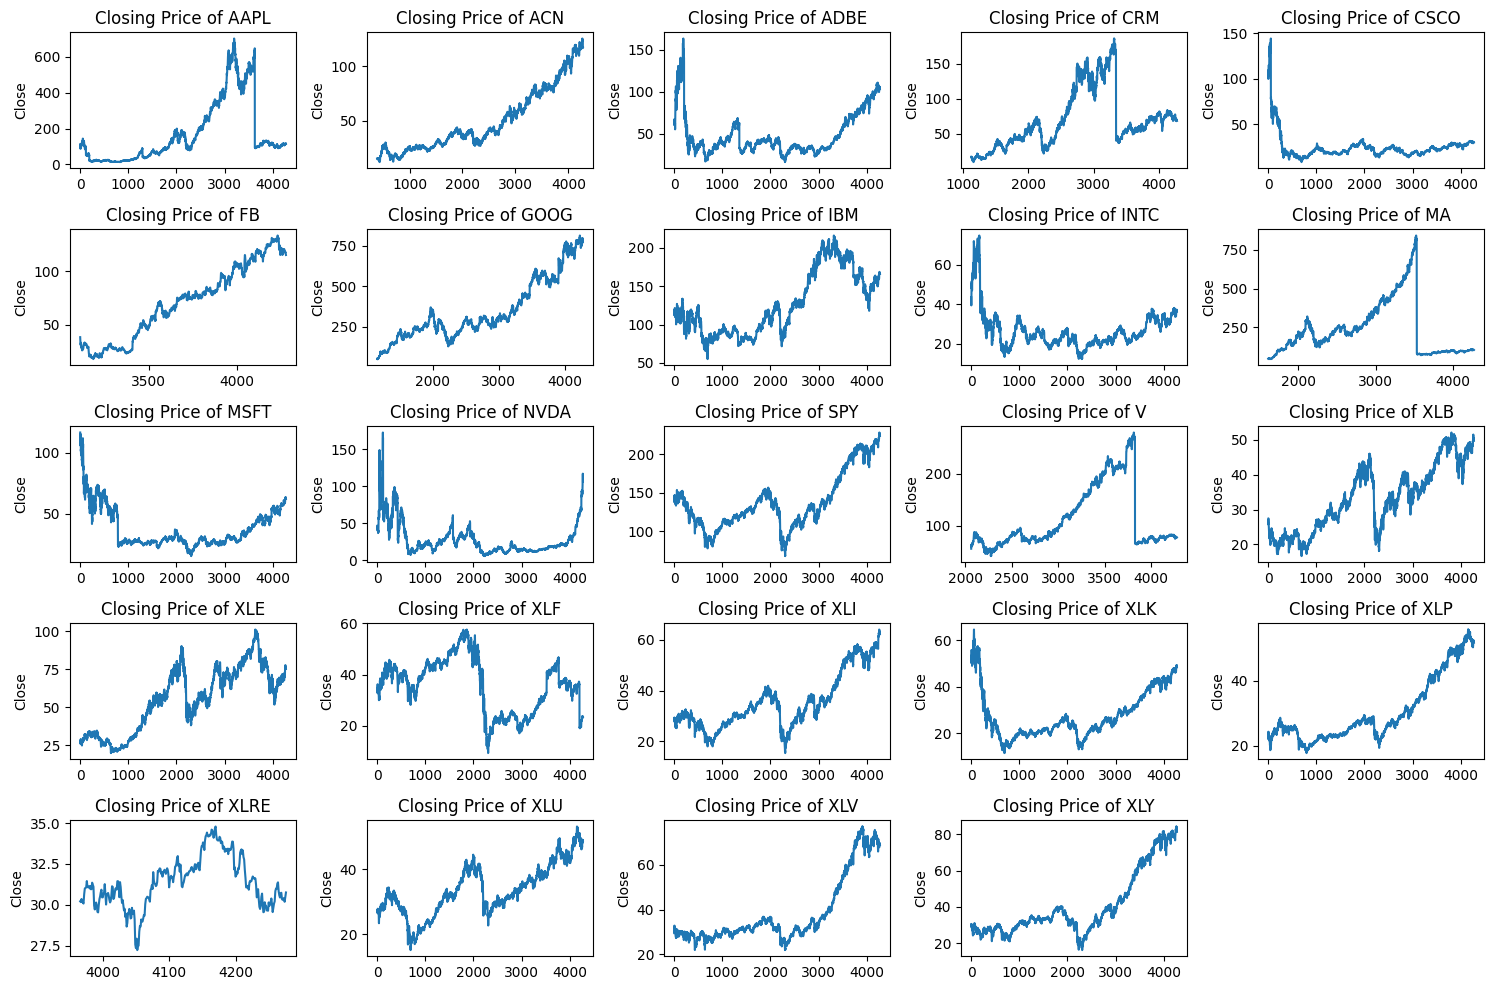

In [231]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(ticker_list, 1):
    plt.subplot(5, 5, i)
    company = pd.read_csv('./Data/train/'+company+'.csv')
    company['Close'].plot()
    plt.ylabel('Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {ticker_list[i - 1]}")
    
plt.tight_layout()

Each subplot presents a line plot of the historical closing prices for a specific stock. The x-axis represents the time, and the y-axis represents the closing price. Each subplot has a title indicating the stock ticker.

From these plots, we can observe the following:

- The closing prices of the stocks vary greatly in their scale and range, making it essential to **normalize or scale the data** before comparing or combining them for analysis.
- Some stocks exhibit a general upward trend in their closing prices, indicating an** increase in the value of the stock over time**. This upward trend could be a result of company growth, positive market sentiment, or other factors influencing the stock price.
- Some stocks **show periods of high volatility**, where the closing prices experience rapid fluctuations within a short time frame. This volatility could be due to company-specific news, earnings reports, or broader market events that impact investor sentiment and trading activity.
- Certain stocks might **display periods of relatively low volatility**, where the closing prices remain relatively stable. These periods of low volatility could be due to stable company performance, low trading volume, or other factors that cause the stock price to remain relatively unchanged.

## Volume 
Volume is a key metric in stock trading and financial analysis, representing the total number of shares or contracts traded for a specific security or market within a given period (usually a day). It provides an indication of the level of interest, activity, and liquidity in a particular stock or market.

High trading volume generally means that the security or market is very active, with a large number of buyers and sellers participating in transactions. This can lead to increased price volatility, as the higher number of trades can cause larger price movements. High volume also typically suggests strong interest in a stock, which could be due to a significant news event, earnings release, or other market developments.

Low trading volume, on the other hand, indicates that there is less interest and activity in a security or market. This can result in less liquidity, making it more difficult to buy or sell shares at desired prices. Additionally, low volume can lead to larger price movements, as even small transactions can have a more significant impact on the price due to the limited number of shares changing hands.



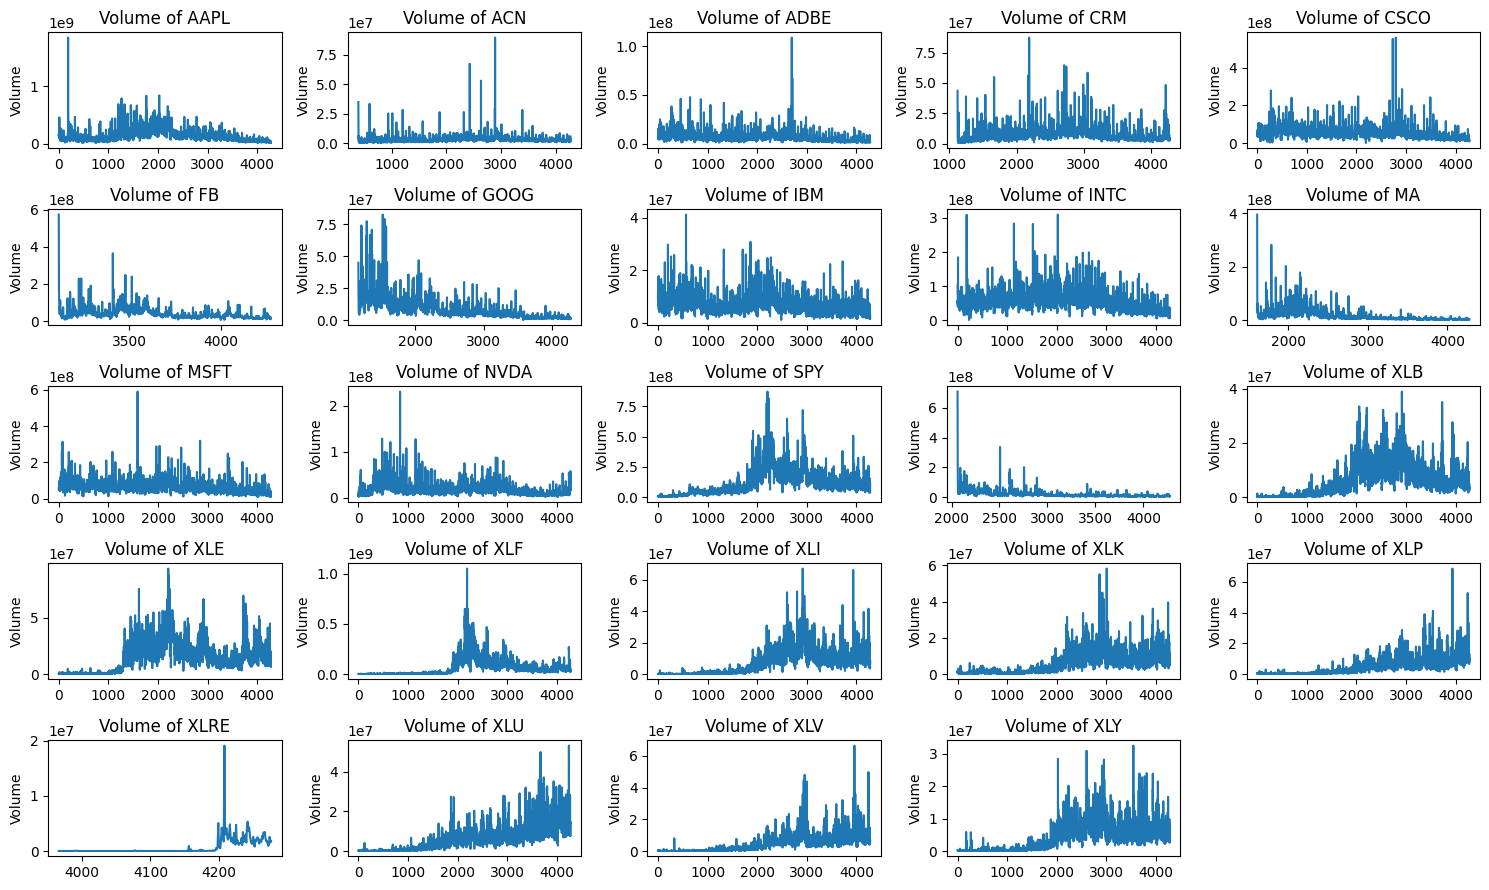

In [232]:
# Let's see a historical view of the volume 
plt.figure(figsize=(15,9))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(ticker_list, 1):
    plt.subplot(5, 5, i)
    company = pd.read_csv('./Data/train/'+company+'.csv')
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Volume of {ticker_list[i - 1]}")
    
plt.tight_layout()

We can see that the y axis is in terms of 1e7/1e8, indicating the volume is very very high for all stocks, proving itself to be a significant indicator.


## Moving Average
Moving Average (MA) is a widely used technical indicator in financial analysis and stock trading. It is a simple tool that calculates the average price of an asset (such as a stock) over a specified period. By doing so, it helps to smooth out short-term fluctuations and noise, making it easier to identify underlying trends or patterns in the data.

The basic idea behind moving averages is to take a series of data points (e.g., daily closing prices of a stock) and compute the average of a certain number of data points, known as the "window" or "period." As new data points are added, the oldest data point is dropped, and the average is recalculated, resulting in a "moving" average.

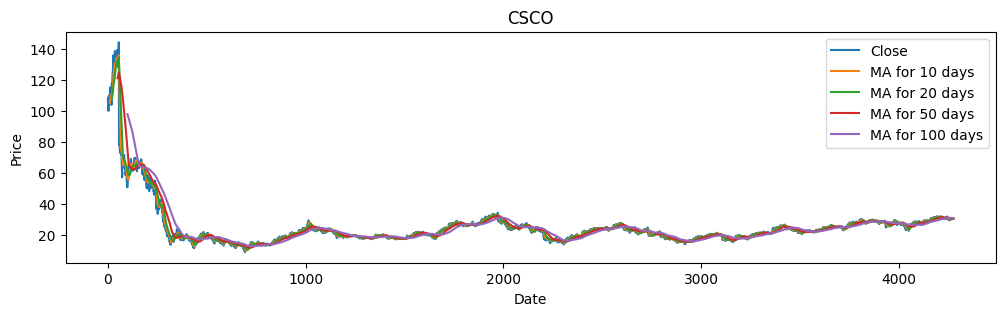

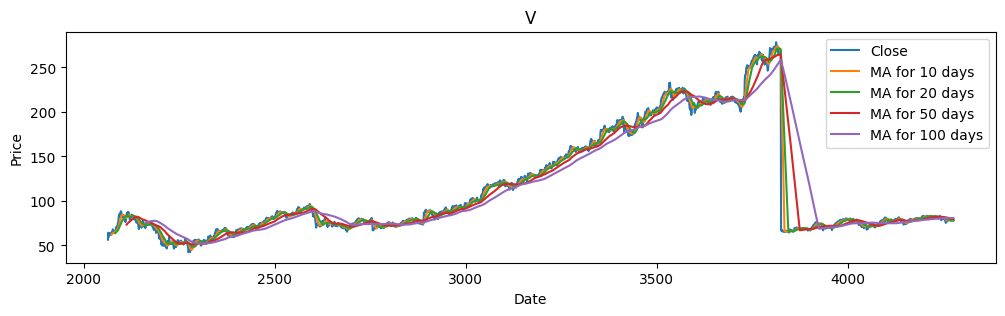

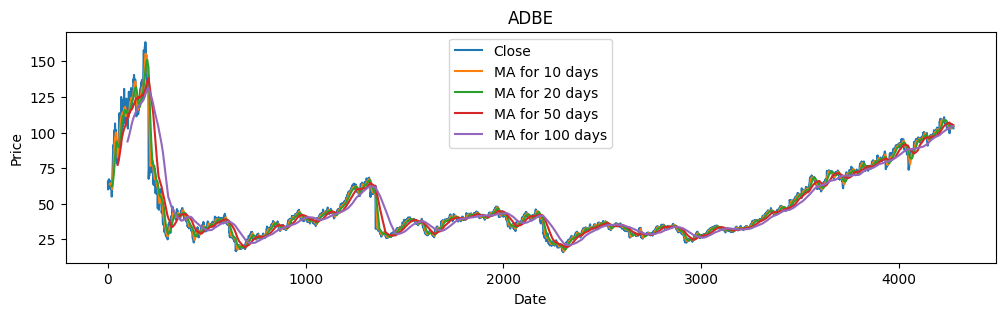

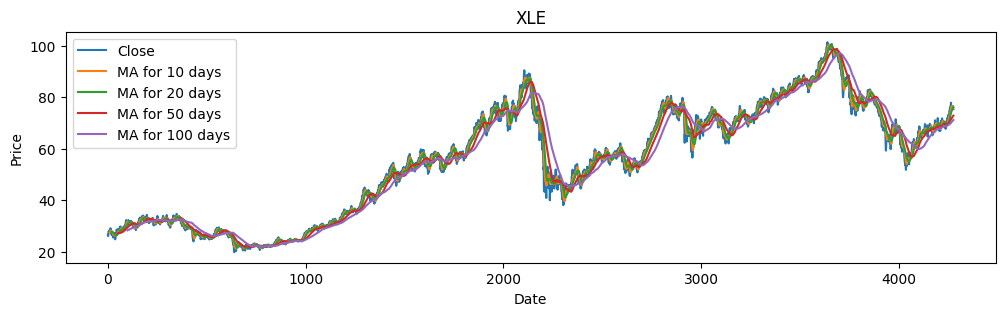

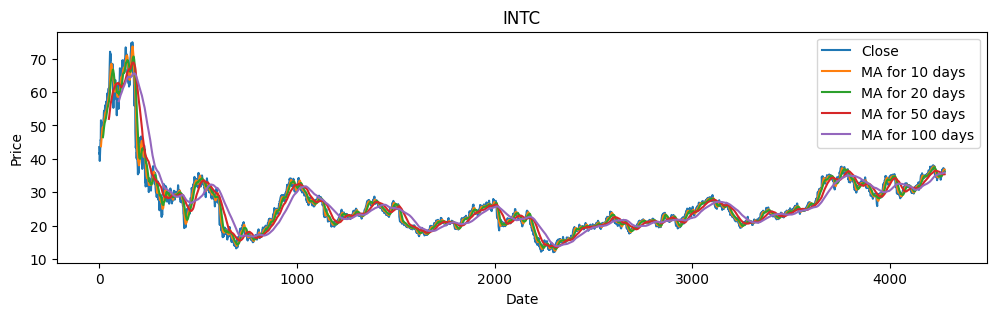

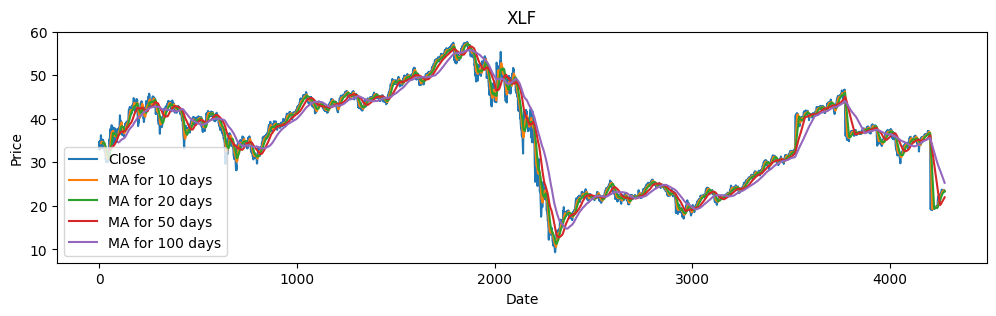

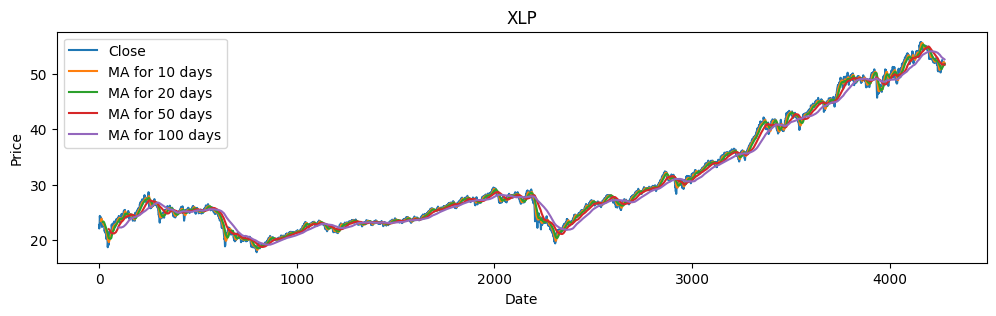

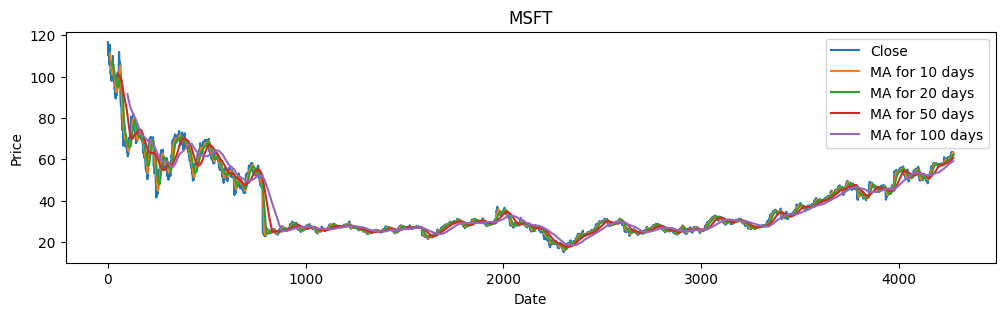

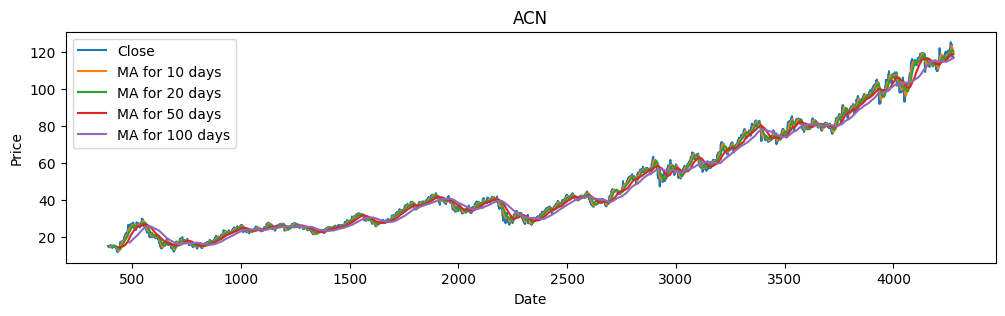

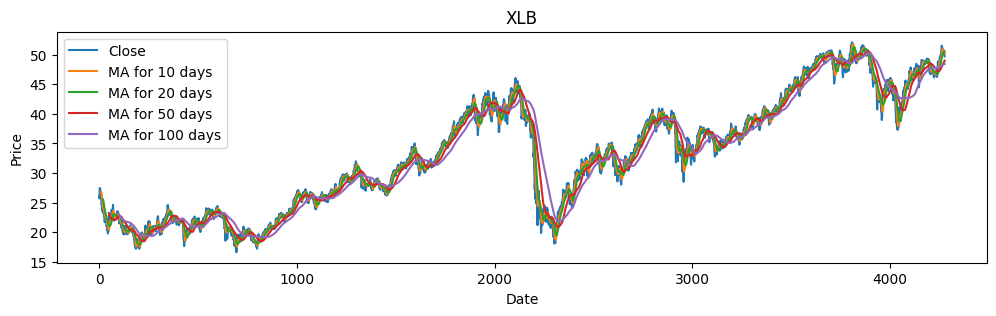

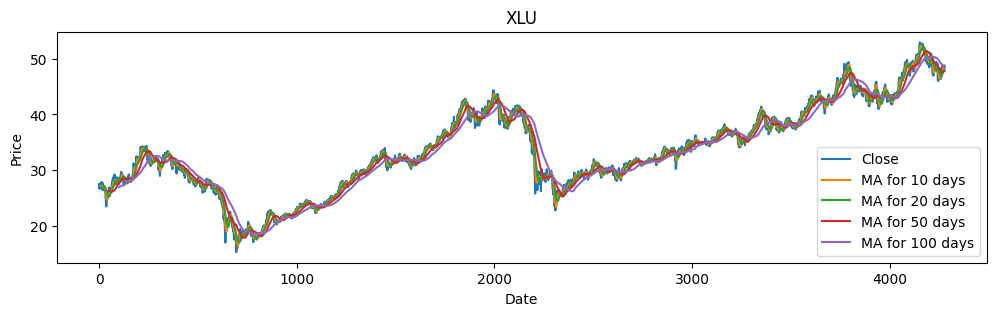

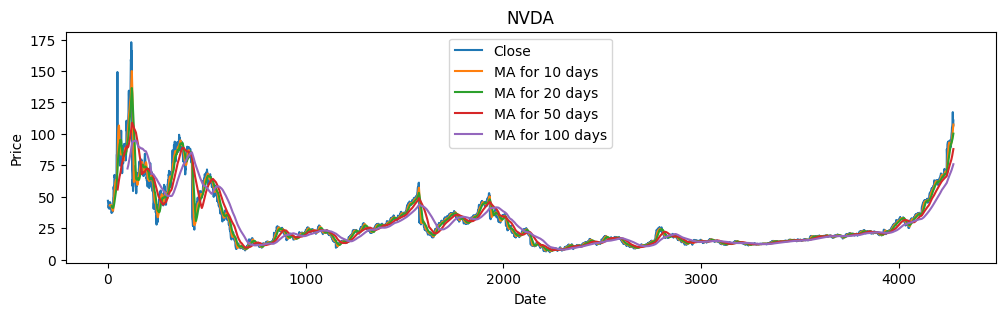

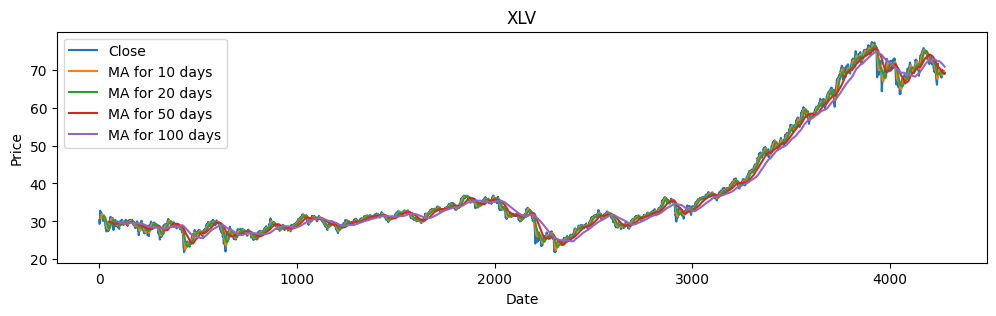

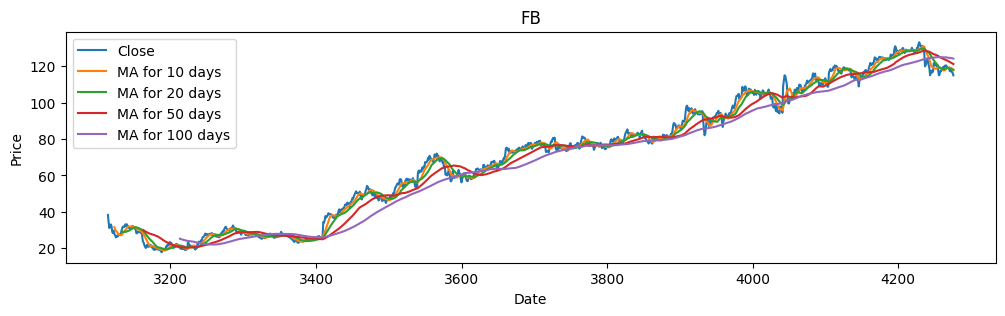

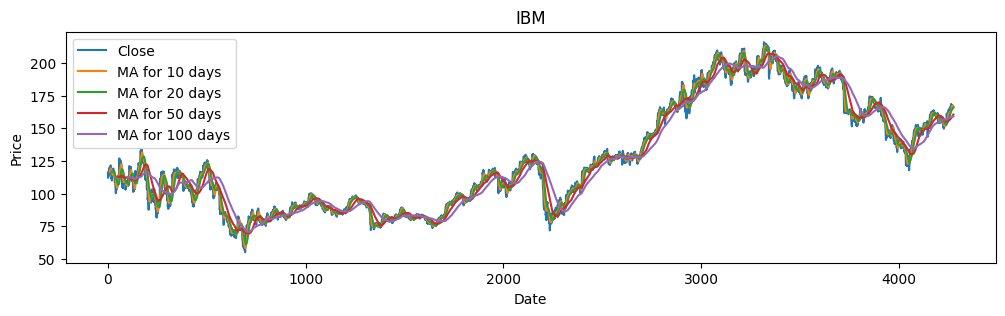

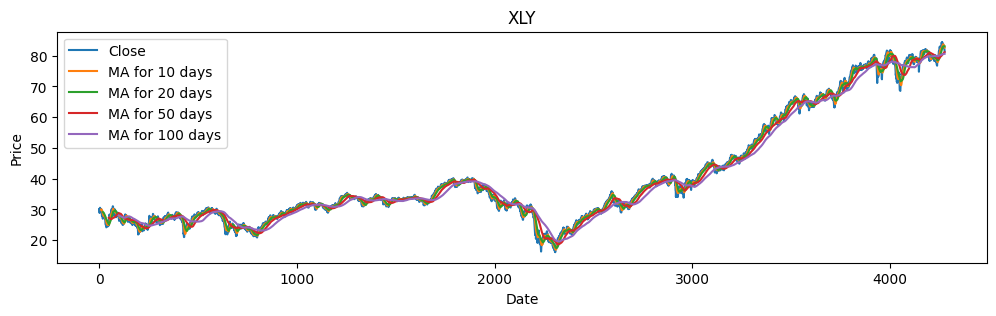

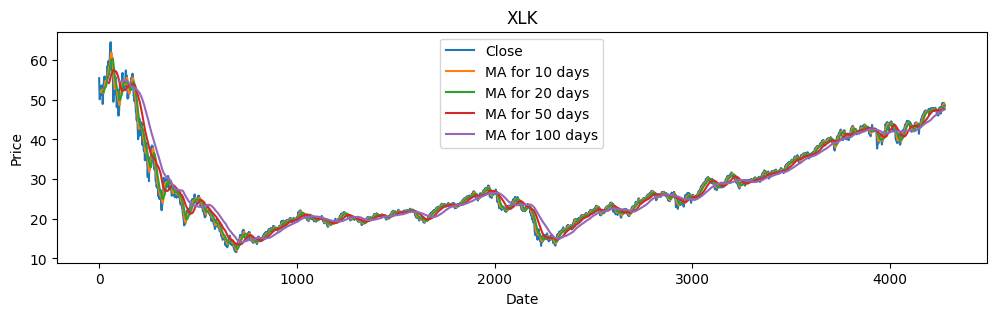

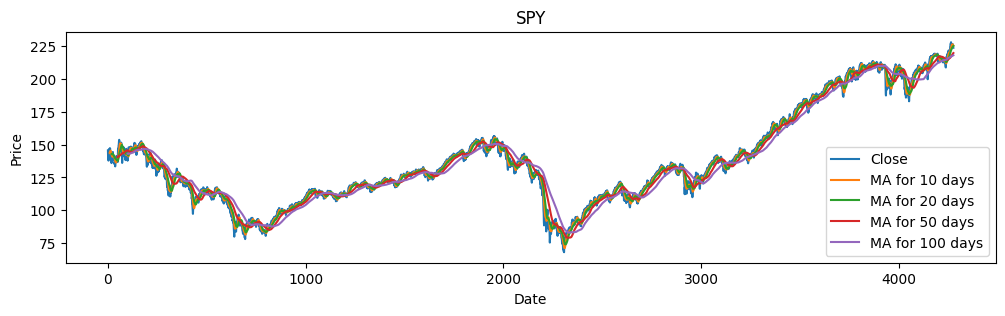

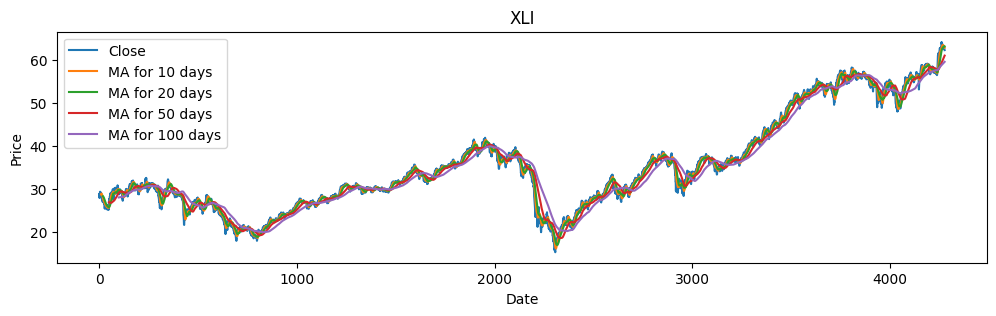

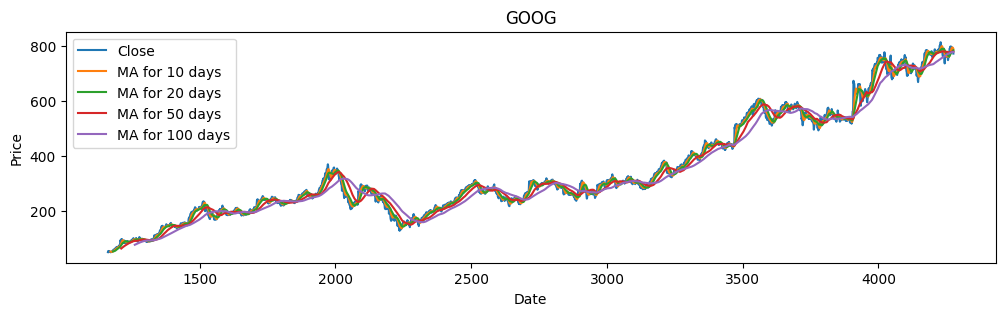

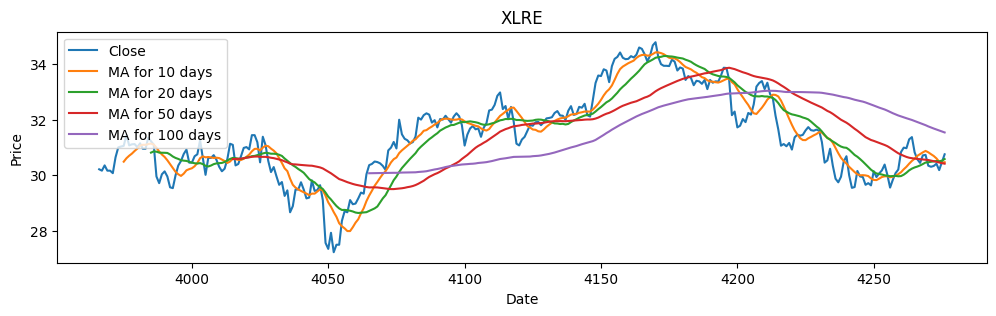

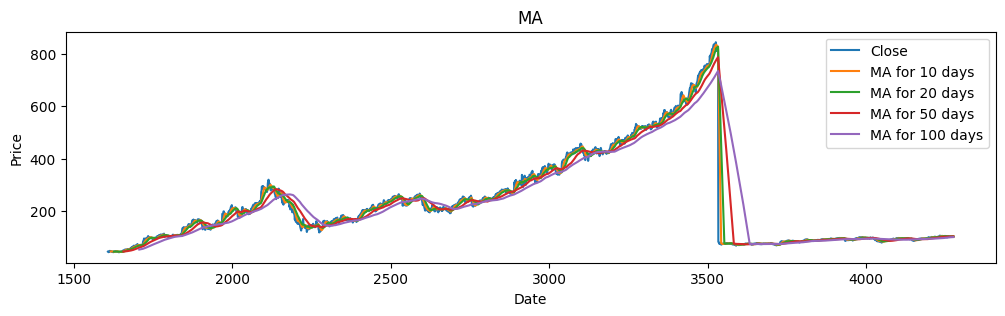

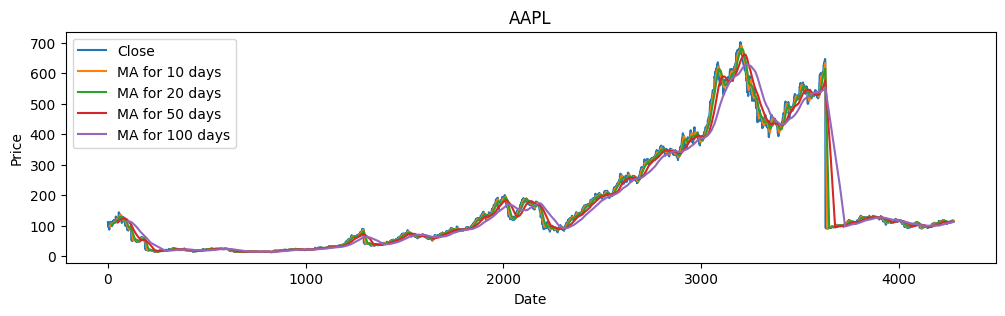

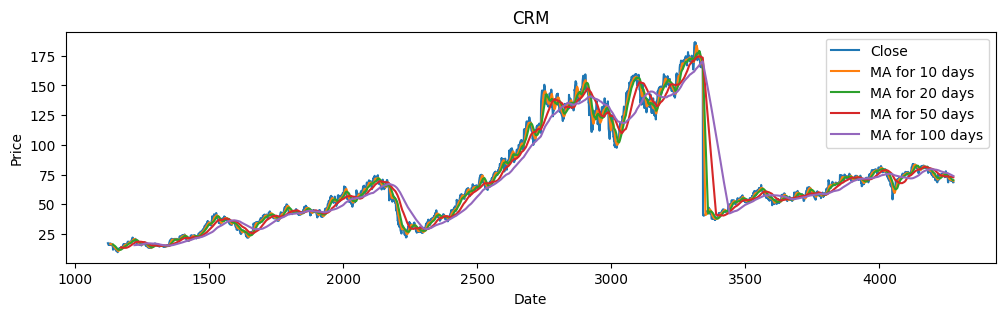

In [233]:
import os

# Get a list of all the CSV files in the ./Data/train/ directory
csv_files = [file for file in os.listdir('./Data/train/') if file.endswith('.csv')]

# Calculate moving averages for different windows for each stock
ma_day = [10, 20, 50,100]
for file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv('./Data/train/' + file)
    
    # Calculate moving averages for different windows
    for ma in ma_day:
        column_name = f"MA for {ma} days"
        df[column_name] = df['Close'].rolling(ma).mean()


    # Plot the moving averages for different windows for each stock
    plt.figure(figsize=(12, 3))
    plt.plot(df['Close'])
    plt.plot(df['MA for 10 days'])
    plt.plot(df['MA for 20 days'])
    plt.plot(df['MA for 50 days'])
    plt.plot(df['MA for 100 days'])
    plt.legend(['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days','MA for 100 days'])
    plt.title(file[:-4])
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()


From the plotted graphs, we can infer that the moving averages for 10 and 20 days seem to capture the stock's price trends effectively while still maintaining a low level of noise. These shorter window lengths allow us to observe short-term trends and fluctuations in the stock's price.

On the other hand, moving averages with longer windows (50 and 100 days) provide a smoother representation of the stock's price trends but might be less responsive to recent changes. These longer windows help to identify long-term trends and filter out short-term noise in the data.



## Returns
The term "return" in the context of stocks refers to the change in the value of an investment over a certain period of time. It is used to measure the performance of an investment, such as stocks, bonds, or mutual funds. In the case of stocks, return is typically expressed as a percentage and represents the change in the stock's price over a specific period.

The formula, df['Close'].pct_change(), calculates the daily return for a stock. It uses the percentage change in the closing price from one day to the next to determine the return. This is a common method for evaluating the daily performance of a stock.

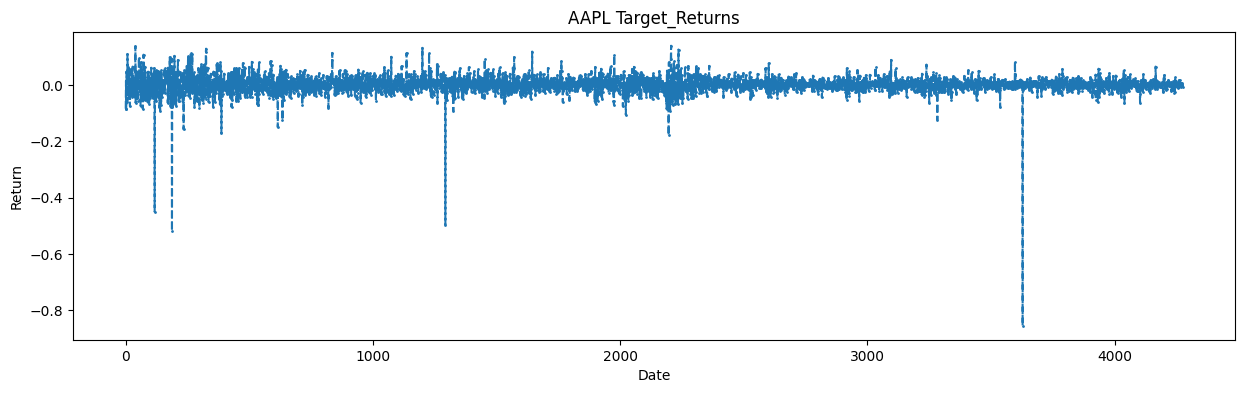

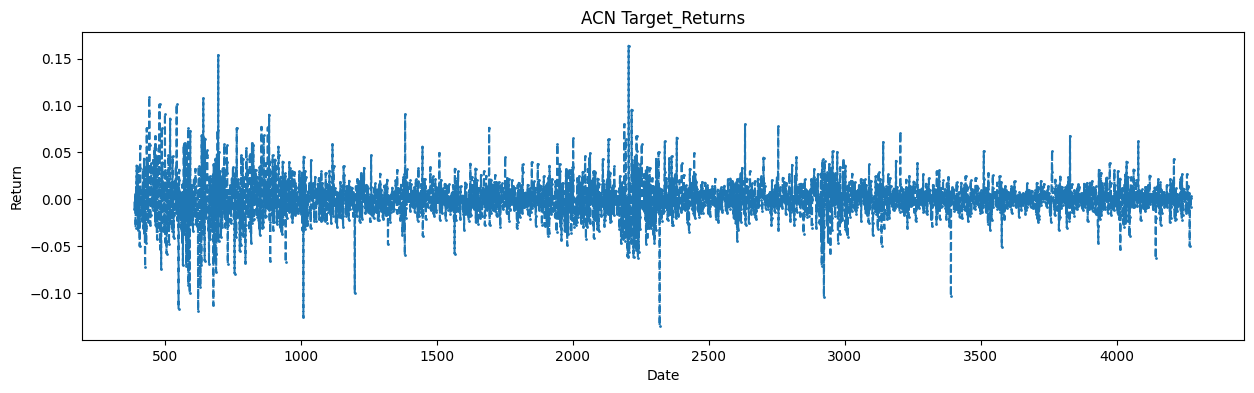

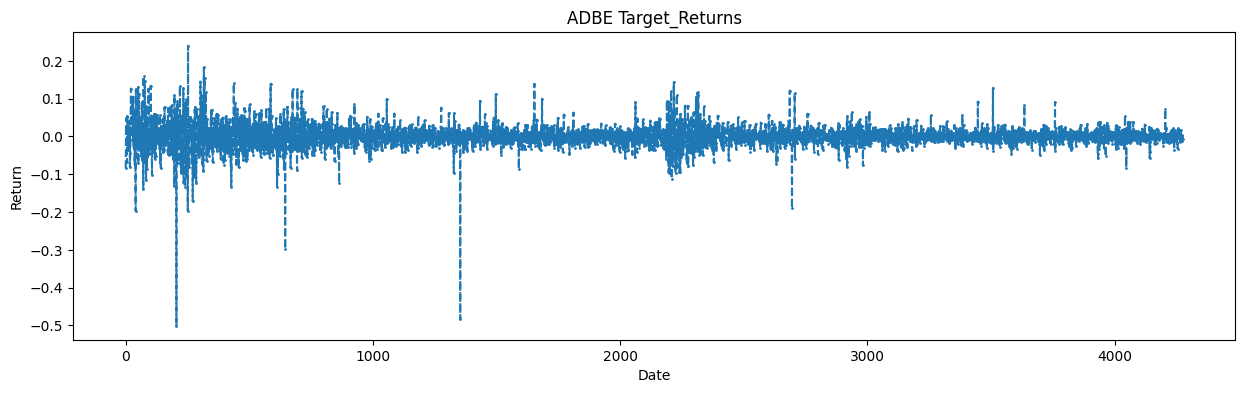

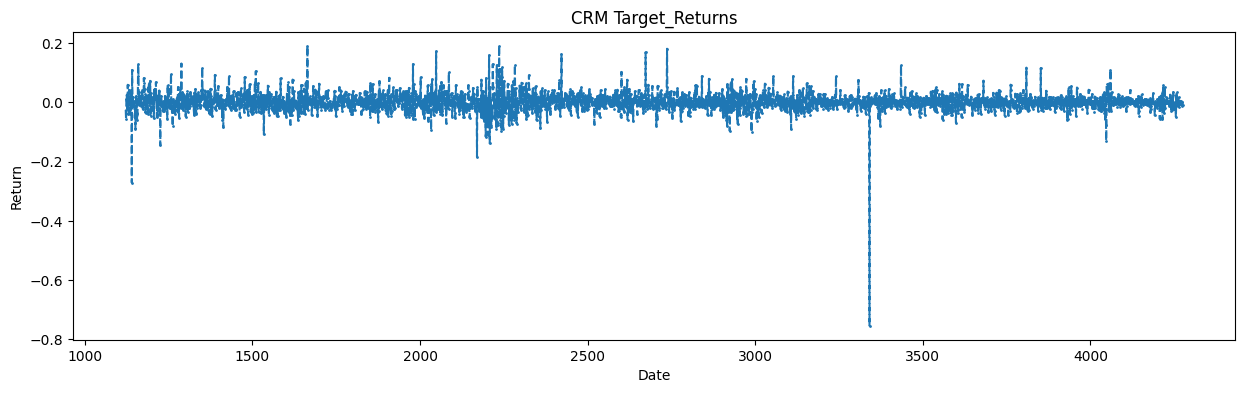

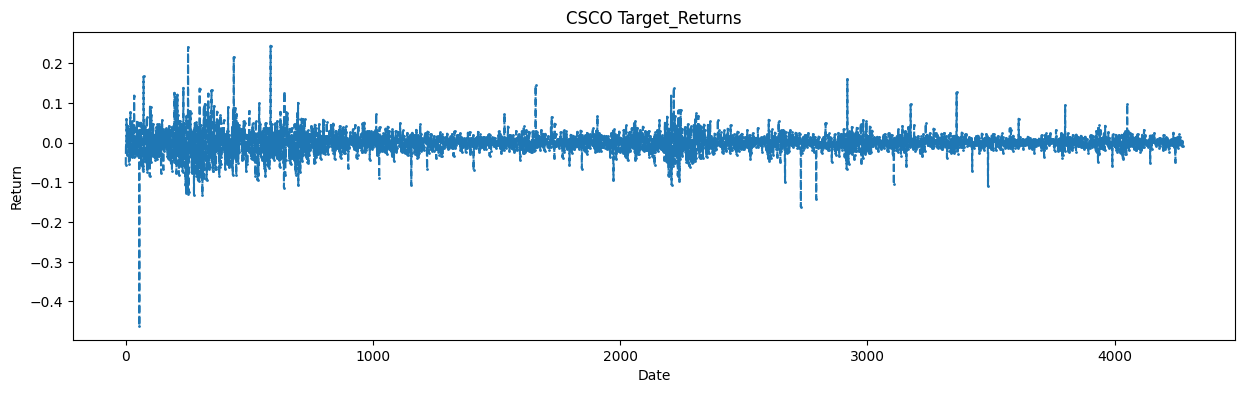

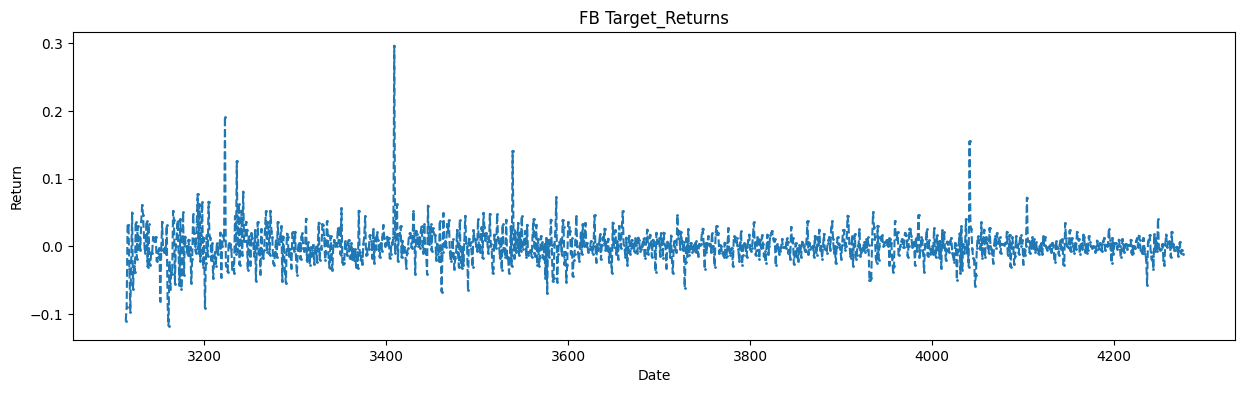

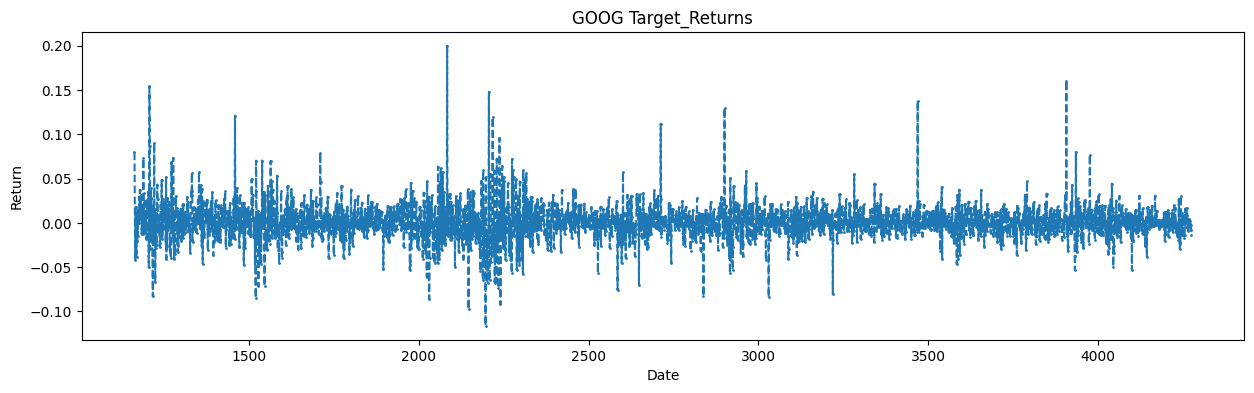

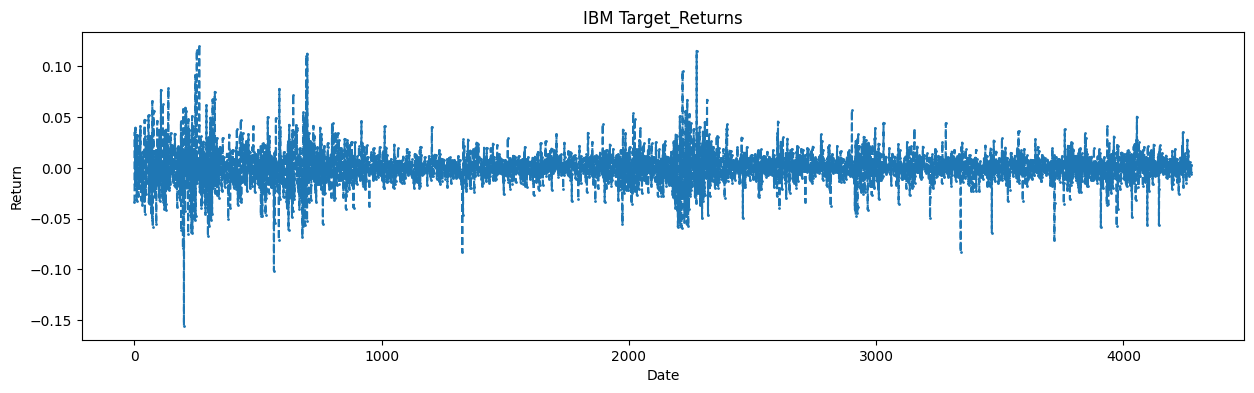

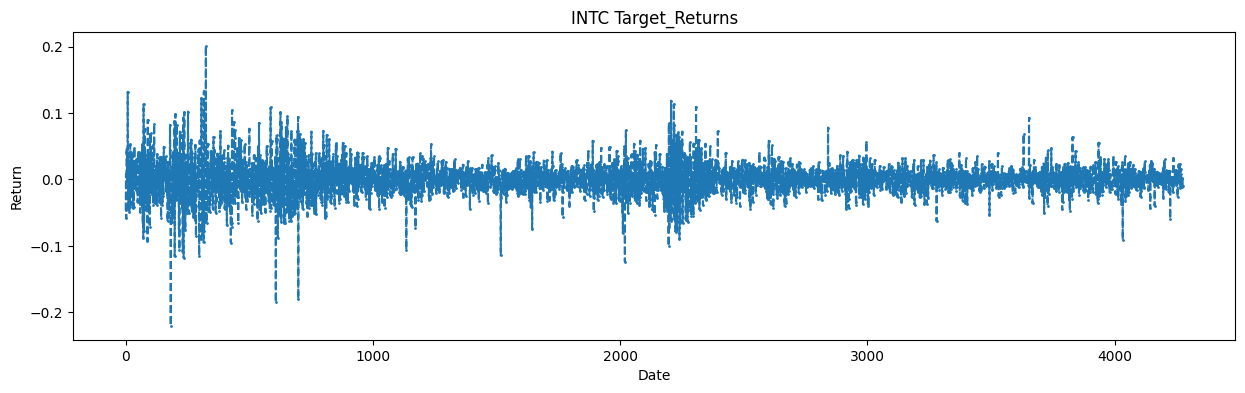

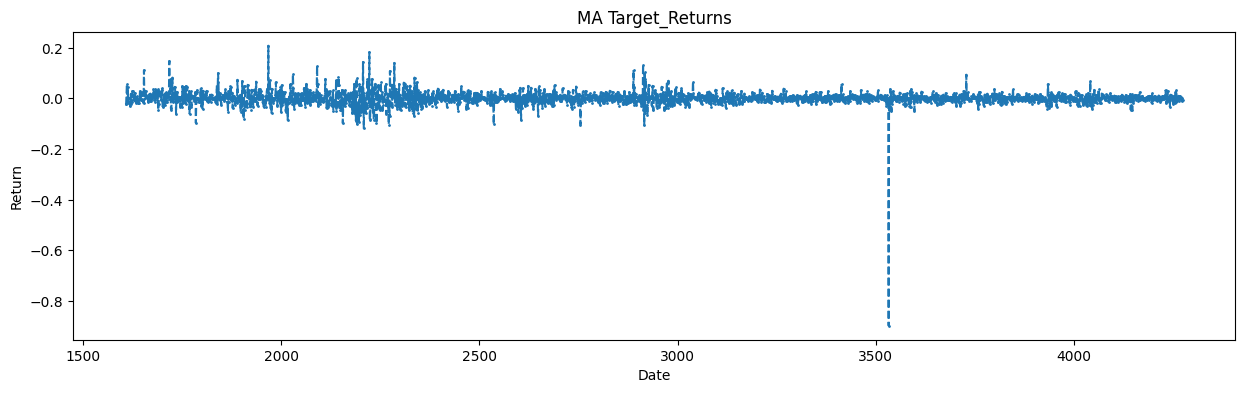

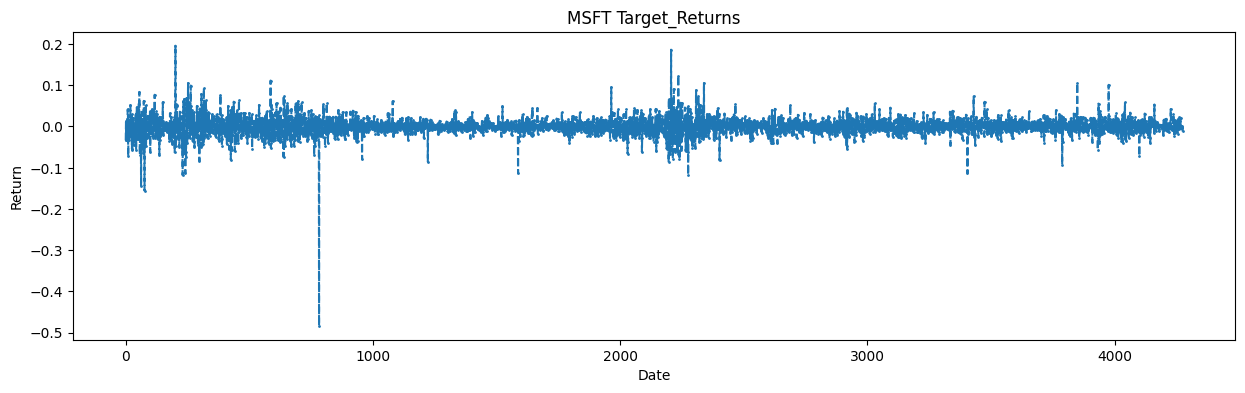

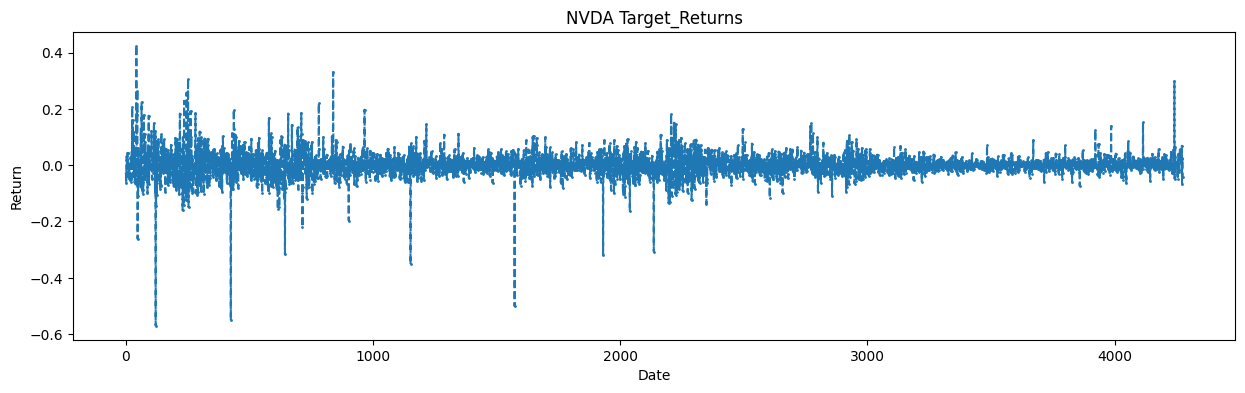

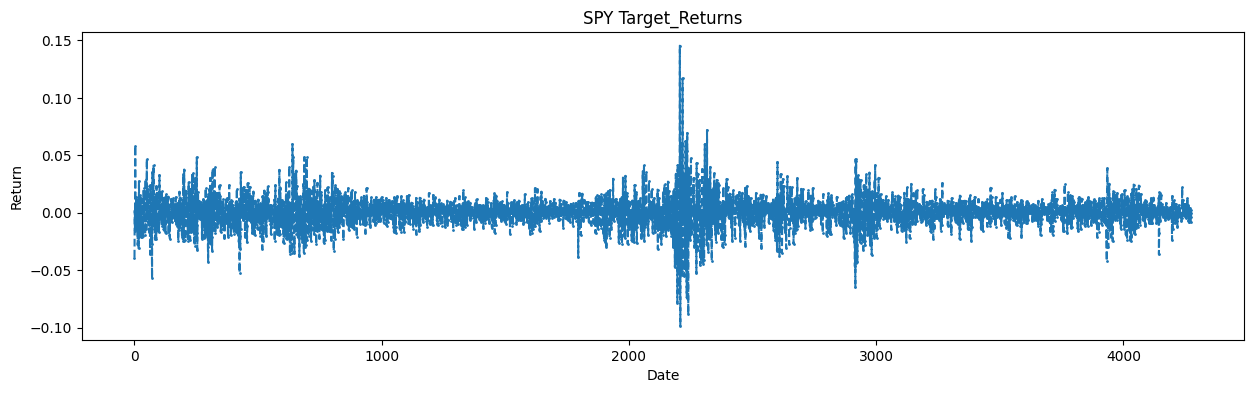

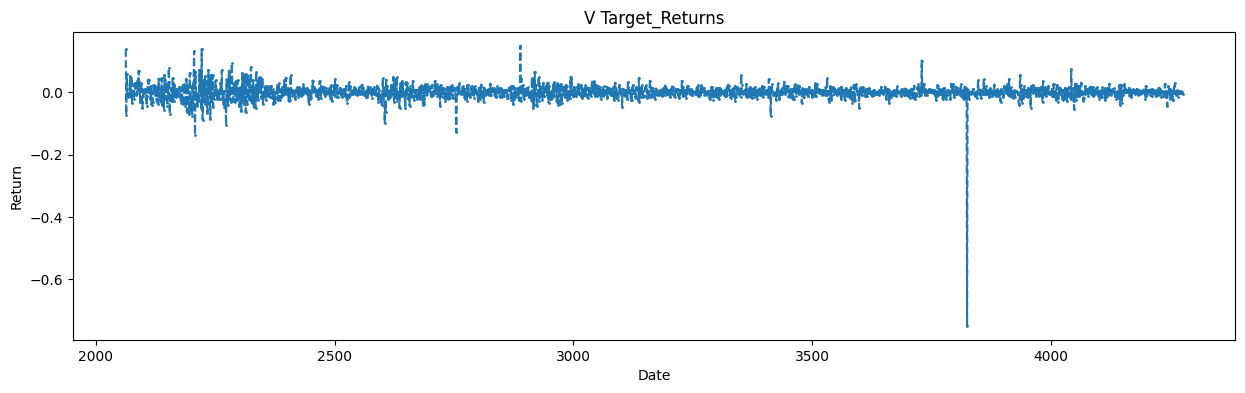

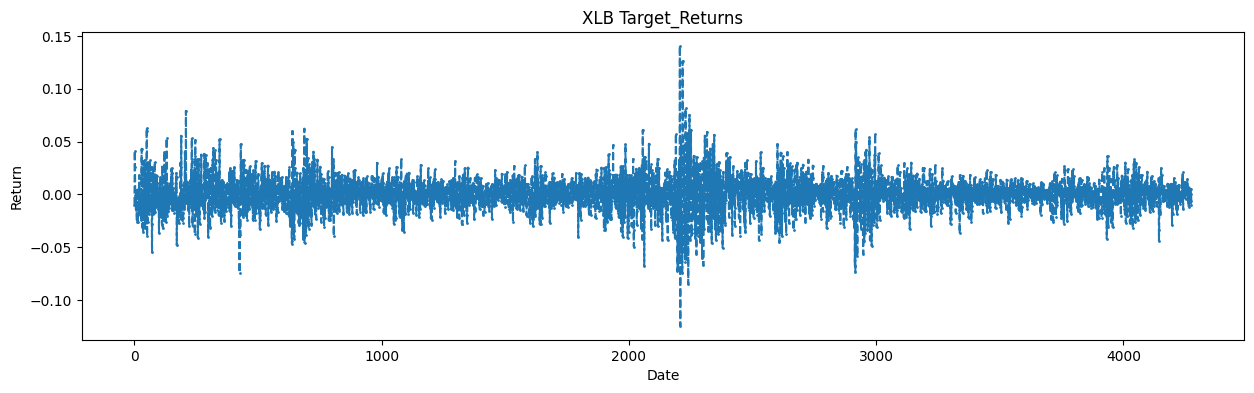

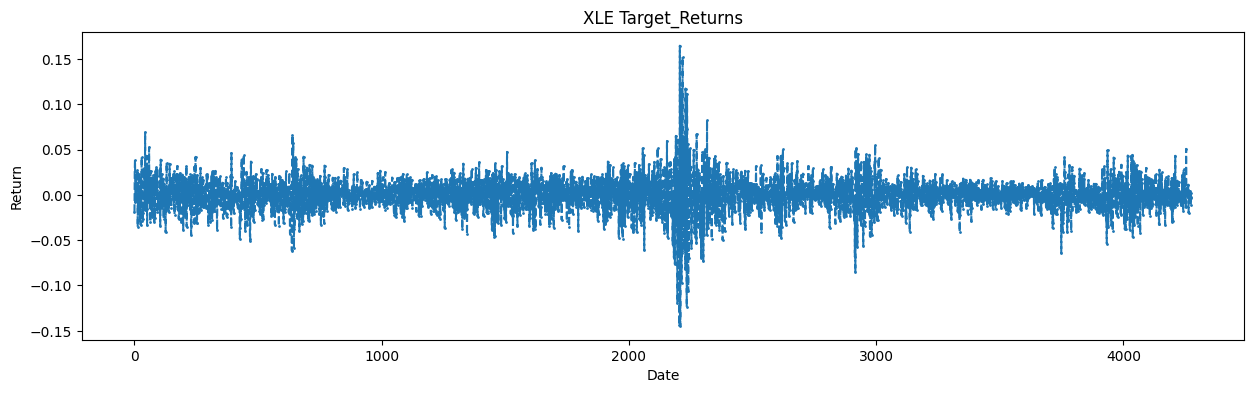

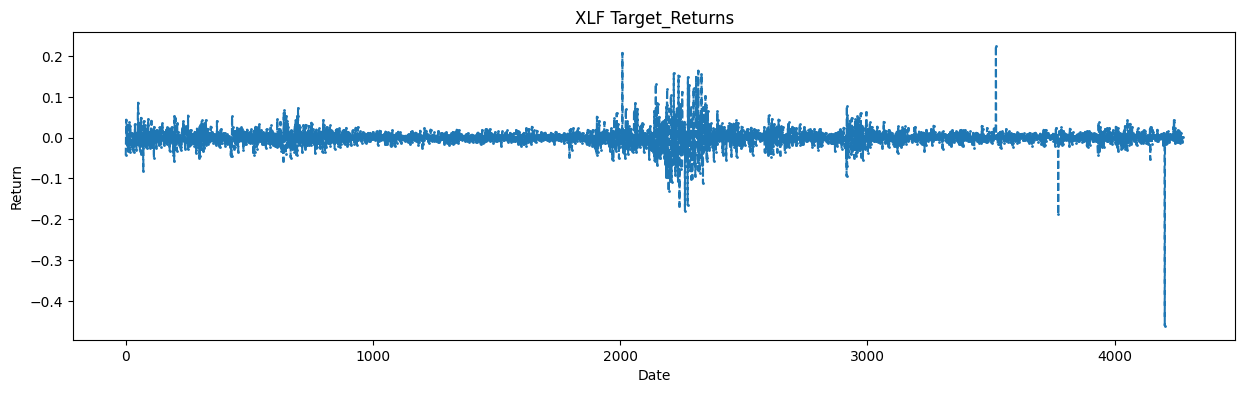

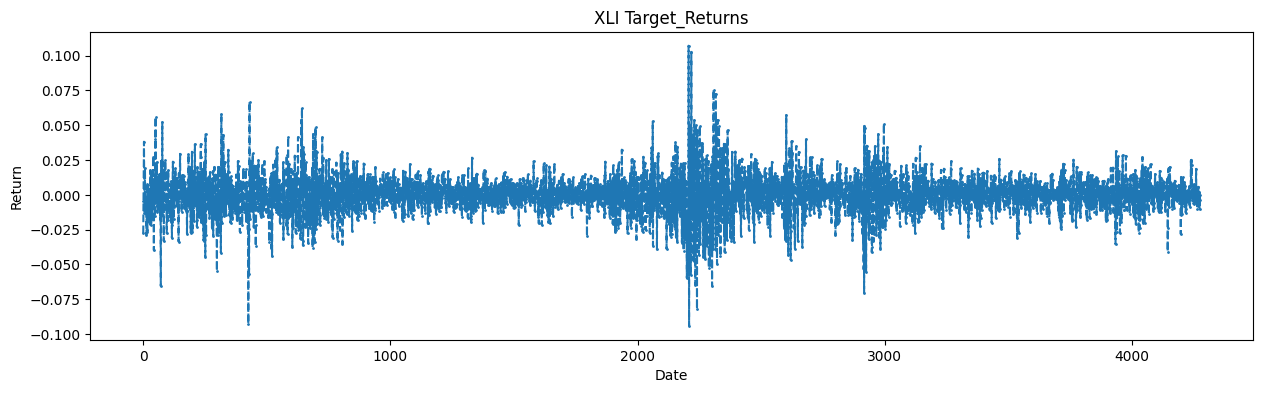

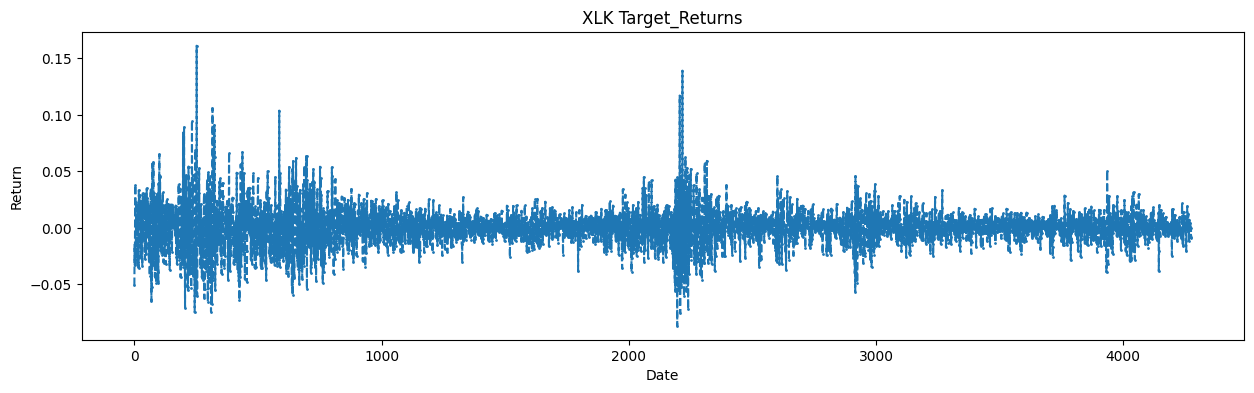

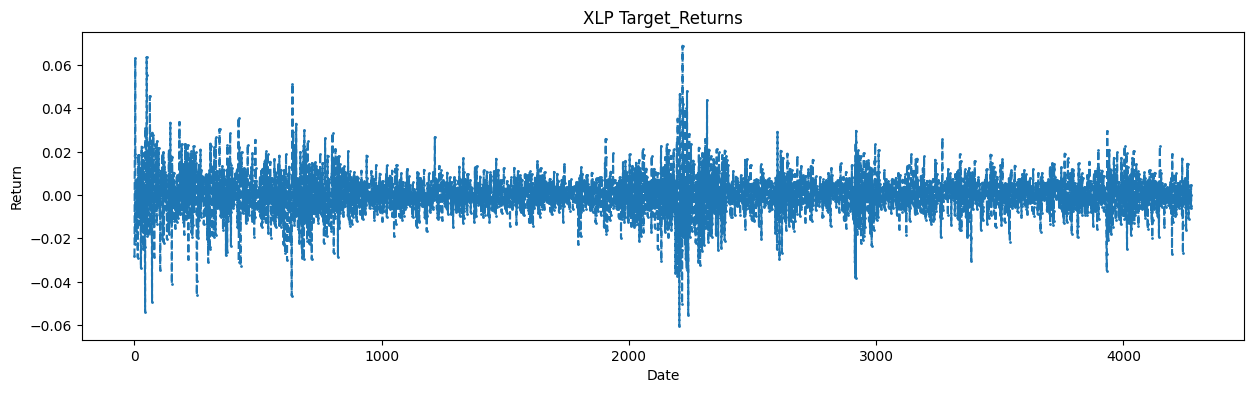

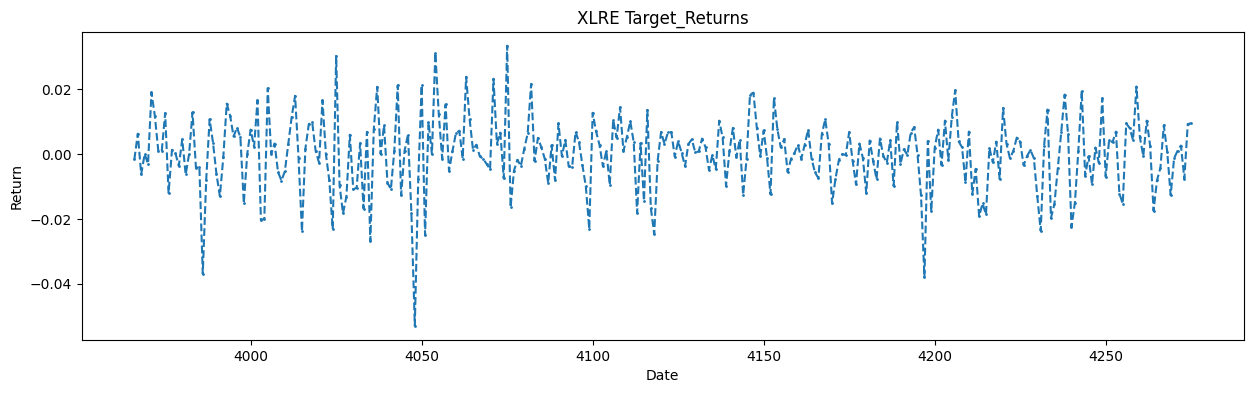

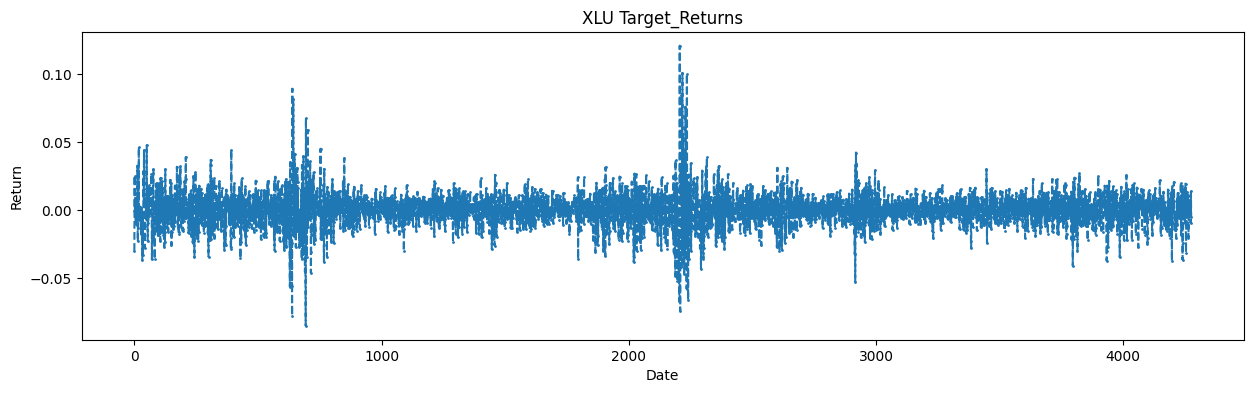

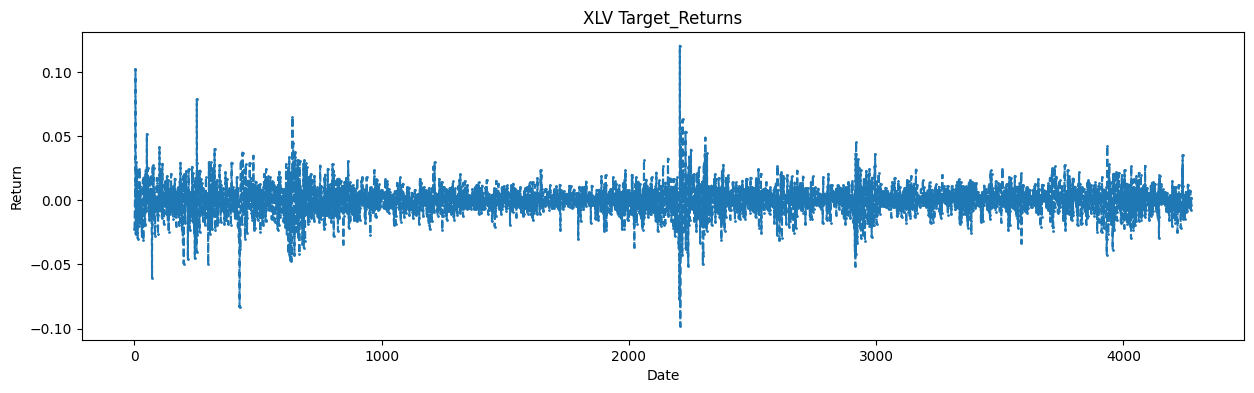

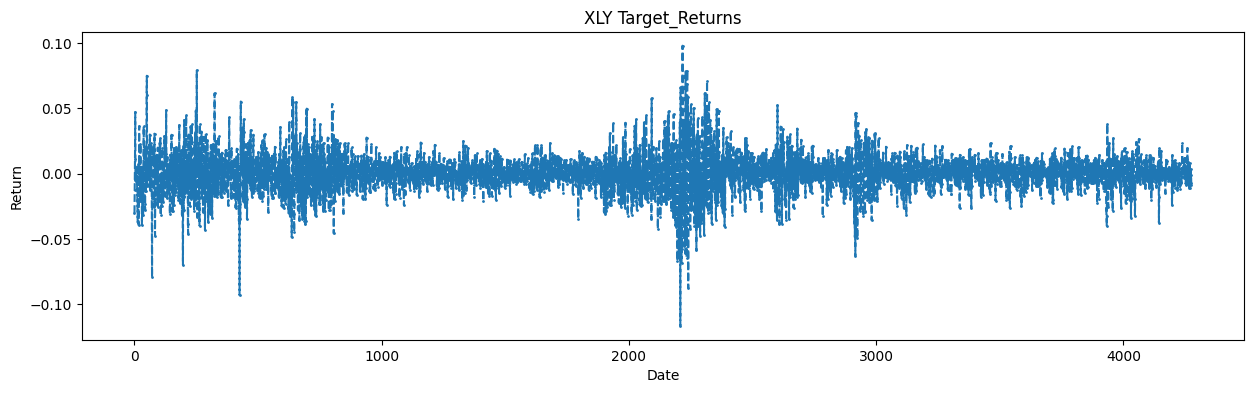

In [234]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_Target_Returns(ticker):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(f'./Data/train/{ticker}.csv')
    
    # Calculate daily_returns
    df['Target_Returns'] = df['Close'].pct_change()
    df['Target_Returns'] = df['Target_Returns'].shift(-1)

    # Plot the Target_Returns
    plt.figure(figsize=(15, 4))
    plt.plot(df['Target_Returns'], linestyle='--', marker='o',markersize=1)
    plt.title(f'{ticker} Target_Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.show()

for ticker in ticker_list:
    plot_Target_Returns(ticker)

The historical stock data for each ticker in the ticker_list is read, and  the daily target returns by taking the percentage change of the 'Close' prices is calculated. **It then shifts the target returns by one step, so the target return represents the next day's return. The target returns are plotted for each ticker in the list.**

The returns of the stocks appear to be stationary, which is an important characteristic in time series analysis. A stationary time series is one whose statistical properties, such as mean, variance, and autocorrelation, remain constant over time. In simpler terms, a stationary series does not exhibit any trends or seasonality and tends to revert to its mean over time.

Stationarity is a desirable property for time series data as it makes the series easier to model and predict. Many time series models, such as ARIMA and GARCH, assume stationarity to provide reliable predictions. In the case of stock returns, a stationary series implies that the returns are more predictable and do not exhibit any persistent patterns or trends, which is useful for forecasting purposes.

In the plots generated by the code, the stock returns appear to be fluctuating around a constant mean and do not exhibit any significant trends or seasonality, suggesting that they are stationary. This observation is crucial for the subsequent analysis and modeling of these stock returns.

# 2. Feature Engineering


# Read sector ETFs data
- sp500 = pd.read_csv('./data/train/SPY.csv', index_col='Dt', parse_dates=True)
- energy = pd.read_csv('./data/train/XLE.csv', index_col='Dt', parse_dates=True)
- finance = pd.read_csv('./data/train/XLF.csv', index_col='Dt', parse_dates=True)
- material = pd.read_csv('./data/train/XLB.csv', index_col='Dt', parse_dates=True)
- industrial = pd.read_csv('./data/train/XLI.csv', index_col='Dt', parse_dates=True)
- consumerStaples = pd.read_csv('./data/train/XLP.csv', index_col='Dt', parse_dates=True)
- tech = pd.read_csv('./data/train/XLK.csv', index_col='Dt', parse_dates=True)
- realEstate = pd.read_csv('./data/train/XLRE.csv', index_col='Dt', parse_dates=True)
- utilities = pd.read_csv('./data/train/XLU.csv', index_col='Dt', parse_dates=True)
- healthCare = pd.read_csv('./data/train/XLV.csv', index_col='Dt', parse_dates=True)
- consumerDiscretionary = pd.read_csv('./data/train/XLY.csv', index_col='Dt', parse_dates=True)

In [235]:
import pandas as pd
import talib as talib

def add_indicators(type, file_name):

    data = pd.read_csv(file_name)
    # Load data
    data=data.rename(columns={'Adj Close':'Adj'})
    
    # Add indicators
    short_ema = 12
    long_ema = 26
    signal_period = 9
    
    #MACD
    data['MACD'], data['MACD_Signal'], data['MACD_Hist'] = talib.MACD(data['Close'], fastperiod=short_ema, slowperiod=long_ema, signalperiod=signal_period)

    data['RSI'] = ta.rsi(data.Close, length=10)
    data['ATR_5'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=5)
    data['ATR_10'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=10)
    data['MIDPOINT']=talib.MIDPOINT(data['Close'])/data['Close']
    data['MIDPRICE']=talib.MIDPRICE(data['High'],data['Low'])/data['Close']

    #Bollinger Bands
    upper, middle, lower = talib.BBANDS(data['Close'])
    data['Bollinger_upper'] = upper
    data['Bollinger_middle'] = middle
    data['Bollinger_lower'] = lower

    # Read sector ETFs data

    sector_etfs = ['SPY', 'XLE', 'XLF', 'XLB', 'XLI', 'XLP', 'XLK',  'XLU', 'XLV', 'XLY']
    if (type == "train"):
        sector_etfs_data = {etf: pd.read_csv(f'./data/train/{etf}.csv', index_col='Dt', parse_dates=True) for etf in sector_etfs}
    elif (type == "sample"):
        sector_etfs_data = {etf: pd.read_csv(f'./data/sample/{etf}.csv', index_col='Dt', parse_dates=True) for etf in sector_etfs}
    else:
        sector_etfs_data = {etf: pd.read_csv(f'./data/test/{etf}.csv', index_col='Dt', parse_dates=True) for etf in sector_etfs}

    # Calculate returns for sector ETFs
    for etf, data in sector_etfs_data.items():
        data[f'{etf}_Returns'] = data['Close'].pct_change().shift(-1)

    # Merge sector ETFs returns with data
    data = pd.concat([data] + [sector_etfs_data[etf][[f'{etf}_Returns']] for etf in sector_etfs], axis=1).dropna()

    
    # Shift Target_Returns column 
    data['Target_Returns'] = data['Close'].pct_change()
    data['Target_Returns'] = data['Target_Returns'].shift(-1)


    # Drop rows with NaN
    data = data.dropna()
    
    return data


# TECHNICAL INDICATORS 

- ## MACD
    The Moving Average Convergence Divergence (MACD) is a technical indicator used in financial analysis to identify changes in the strength, direction, momentum, and duration of a trend in a stock's price. It is calculated by subtracting a longer-term Exponential Moving Average (EMA) from a shorter-term EMA. The MACD consists of two lines, the MACD line, and the signal line, which are used together to generate buy and sell signals.

    In this example, short_ema is the shorter EMA period (typically 12), long_ema is the longer EMA period (typically 26), and signal_period is the period for the signal line (typically 9). The ta.MACD function returns the MACD line, the signal line, and the histogram values, which are stored in the 'MACD', 'MACD_Signal', and 'MACD_Hist' columns of the data DataFrame, respectively.

- ## RSI
    The Relative Strength Index (RSI) is a popular momentum oscillator used in technical analysis to measure the speed and change of price movements. It ranges between 0 and 100 and is typically used to identify overbought or oversold conditions in a market, helping traders to determine potential entry and exit points.

    The RSI is calculated using the average gain and average loss over a specified period (usually 14 periods). A high RSI value, typically above 70, indicates that an asset may be overbought, suggesting that it could be due for a price correction or reversal. Conversely, a low RSI value, usually below 30, indicates that an asset may be oversold, implying that the price may rebound.

- ## MIDPOINT
    The MIDPOINT function in the talib library calculates the midpoint of the close prices over a specified time period. The midpoint is the average of the highest and lowest close prices during that period. It is often used as a reference point to determine price trends and potential support or resistance levels.

    The ta.MIDPOINT function calculates the midpoint for the 'Close' price data, and then the result is divided by the 'Close' price to get a relative midpoint value. This relative value is stored in the 'MIDPOINT' column of the data DataFrame.

- ## MIDPRICE
    The MIDPRICE function in the talib library calculates the midpoint between the highest and lowest values (high and low prices) over a specified time period. Similar to the MIDPOINT, it can be used to identify price trends, support, and resistance levels.

    The ta.MIDPRICE function calculates the midpoint between the 'High' and 'Low' price data, and then the result is divided by the 'Close' price to get a relative midprice value. This relative value is stored in the 'MIDPRICE' column of the data DataFrame.

- ## BOLLINGER BANDS
    Bollinger Bands is a technical analysis tool developed by John Bollinger in the 1980s. It is used to measure a market's volatility and identify overbought or oversold conditions in the market. Bollinger Bands consist of three lines:

    The middle line, which is typically a moving average (usually a simple moving average) of the asset's price, most commonly calculated over 20 periods.
    The upper line, calculated as the middle line plus a multiple of the asset's standard deviation over the same period (usually 2 standard deviations).
    The lower line, calculated as the middle line minus a multiple of the asset's standard deviation over the same period (usually 2 standard deviations).
    When the market becomes more volatile, the bands widen, and when the market becomes less volatile, the bands contract. Traders can use Bollinger Bands to identify potential entry and exit points, as well as to determine the strength of a trend.






In [236]:
for ticker in ticker_list:
    exec(f'train_data_{ticker} = add_indicators("train", "./Data/train/{ticker}.csv")')
    exec(f'test_data_{ticker} = add_indicators("sample","./Data/sample/{ticker}.csv")')
# train_data_AAPL = add_indicators("./Data/train/AAPL.csv")

In [237]:
train_data_AAPL

Adj Close   Close  Div  Factor     High      Low    Open   
Dt                                                                     
2000-01-03    23.6030  30.125  0.0     1.0  31.0000  29.8590  31.000  \
2000-01-04    22.8930  29.219  0.0     1.0  29.8130  29.0310  29.688   
2000-01-05    22.6114  28.859  0.0     1.0  29.3461  28.7190  29.344   
2000-01-06    22.8685  29.188  0.0     1.0  29.4060  28.9991  29.047   
2000-01-07    23.9458  30.563  0.0     1.0  30.5630  29.5000  29.500   
...               ...     ...  ...     ...      ...      ...     ...   
2016-12-21    80.6102  83.530  0.0     1.0  83.6200  83.3486  83.560   
2016-12-22    79.7416  82.630  0.0     1.0  83.4100  82.4950  83.380   
2016-12-23    79.5679  82.450  0.0     1.0  82.7650  82.3510  82.610   
2016-12-27    79.8767  82.770  0.0     1.0  83.1000  82.5100  82.510   
2016-12-28    79.3267  82.200  0.0     1.0  83.0300  82.1800  82.950   

               Volume  XLY_Returns  SPY_Returns  XLE_Returns  XLF_Returns   
Dt                                                                          
2000-01-03   212900.0    -0.030075    -0.039109    -0.018823    -0.043723  \
2000-01-04   177200.0    -0.012321     0.001789     0.026359    -0.007877   
2000-01-05   124600.0     0.011400    -0.016071     0.038542     0.043925   
2000-01-06   135800.0     0.047108     0.058076     0.010691     0.016580   
2000-01-07    70000.0    -0.005137     0.003431    -0.008334    -0.017657   
...               ...          ...          ...          ...          ...   
2016-12-21  2702800.0    -0.010775    -0.001727     0.004073    -0.002542   
2016-12-22  4461000.0    -0.002178     0.001464    -0.000916     0.001699   
2016-12-23  2837000.0     0.003881     0.002481     0.002227     0.001272   
2016-12-27  6101100.0    -0.006887    -0.008264    -0.010847    -0.010165   
2016-12-28  3857700.0    -0.001338    -0.000223    -0.001982    -0.007274   

            XLB_Returns  XLI_Returns  XLP_Returns  XLK_Returns  XLU_Returns   
Dt                                                                            
2000-01-03    -0.009627    -0.027631    -0.028176    -0.050741    -0.030161  \
2000-01-04     0.041292    -0.004457     0.017685    -0.014841     0.025239   
2000-01-05     0.025690     0.013430     0.018756    -0.033157    -0.001722   
2000-01-06    -0.000582     0.038096     0.063389     0.017456     0.008587   
2000-01-07    -0.003424     0.000000    -0.022441     0.038000     0.003420   
...                 ...          ...          ...          ...          ...   
2016-12-21    -0.004168    -0.001903    -0.001537    -0.002040     0.003509   
2016-12-22     0.001993     0.000953     0.001925     0.001022    -0.000206   
2016-12-23     0.005371     0.002064    -0.000192     0.004084     0.000823   
2016-12-27    -0.010091    -0.010456    -0.006148    -0.008949    -0.009455   
2016-12-28     0.000000    -0.000320     0.004639     0.000205     0.013488   

            XLV_Returns  XLY_Returns  Target_Returns  
Dt                                                    
2000-01-03    -0.022709    -0.030075       -0.030075  
2000-01-04    -0.008950    -0.012321       -0.012321  
2000-01-05     0.003203     0.011400        0.011400  
2000-01-06     0.012195     0.047108        0.047108  
2000-01-07     0.102259    -0.005137       -0.005137  
...                 ...          ...             ...  
2016-12-21     0.001307    -0.010775       -0.010775  
2016-12-22     0.007543    -0.002178       -0.002178  
2016-12-23     0.002016     0.003881        0.003881  
2016-12-27    -0.007615    -0.006887       -0.006887  
2016-12-28     0.001737    -0.001338       -0.001338  

[4275 rows x 20 columns]

In [238]:
test_data_AAPL

Adj Close  Close  Div  Factor    High     Low   Open      Volume   
Dt                                                                             
2017-01-03    79.0087  81.88  0.0     1.0  82.340  81.380  82.05  14050515.0  \
2017-01-04    80.0605  82.97  0.0     1.0  83.060  82.160  82.24   5493835.0   
2017-01-05    80.0026  82.91  0.0     1.0  82.940  82.440  82.46   4396660.0   
2017-01-06    80.3982  83.32  0.0     1.0  83.570  82.580  82.89   6538097.0   
2017-01-09    80.3306  83.25  0.0     1.0  83.470  83.100  83.29   3855613.0   
...               ...    ...  ...     ...     ...     ...    ...         ...   
2017-12-20    96.3133  98.53  0.0     1.0  99.125  98.490  99.03   2464500.0   
2017-12-21    96.9389  99.17  0.0     1.0  99.390  98.580  98.79   2359901.0   
2017-12-22    96.7532  98.98  0.0     1.0  99.040  98.790  98.86   3221867.0   
2017-12-26    96.9682  99.20  0.0     1.0  99.310  98.860  98.86   1498337.0   
2017-12-27    96.7727  99.00  0.0     1.0  99.390  98.905  99.38   1866942.0   

            XLY_Returns  SPY_Returns  XLE_Returns  XLF_Returns  XLB_Returns   
Dt                                                                            
2017-01-03     0.013312     0.005949    -0.002101     0.008082     0.014603  \
2017-01-04    -0.000723    -0.000794    -0.002500    -0.010127    -0.002957   
2017-01-05     0.004945     0.003578     0.000923     0.003410     0.000989   
2017-01-06    -0.000840    -0.003301    -0.014495    -0.006797    -0.000198   
2017-01-09     0.003604     0.000000    -0.009092     0.002139     0.000593   
...                 ...          ...          ...          ...          ...   
2017-12-20     0.006495     0.002060     0.021186     0.008605     0.003506   
2017-12-21    -0.001916    -0.000262     0.002089    -0.002844     0.003826   
2017-12-22     0.002223    -0.001196     0.008754    -0.002852    -0.000829   
2017-12-26    -0.002016     0.000487    -0.003306     0.001073     0.001327   
2017-12-27     0.002727     0.002057     0.001520     0.003929     0.004472   

            XLI_Returns  XLP_Returns  XLK_Returns  XLU_Returns  XLV_Returns   
Dt                                                                            
2017-01-03     0.005911     0.000000     0.003484     0.003715     0.007875  \
2017-01-04    -0.002859     0.003276     0.001634     0.001028     0.005114   
2017-01-05     0.005734     0.000960     0.007341     0.003081     0.002827   
2017-01-06    -0.007761    -0.008058    -0.000202    -0.013107     0.004228   
2017-01-09     0.004150    -0.005029     0.000202    -0.003113     0.003509   
...                 ...          ...          ...          ...          ...   
2017-12-20     0.000797    -0.000704    -0.002009    -0.011887    -0.002279   
2017-12-21     0.000265     0.001585    -0.000619     0.001528    -0.003246   
2017-12-22     0.001061     0.002286    -0.006663    -0.005910     0.000241   
2017-12-26     0.002385    -0.000175     0.001092     0.004219     0.001688   
2017-12-27     0.001983    -0.001579     0.001714     0.005539     0.001445   

            XLY_Returns  Target_Returns  
Dt                                       
2017-01-03     0.013312        0.013312  
2017-01-04    -0.000723       -0.000723  
2017-01-05     0.004945        0.004945  
2017-01-06    -0.000840       -0.000840  
2017-01-09     0.003604        0.003604  
...                 ...             ...  
2017-12-20     0.006495        0.006495  
2017-12-21    -0.001916       -0.001916  
2017-12-22     0.002223        0.002223  
2017-12-26    -0.002016       -0.002016  
2017-12-27     0.002727        0.002727  

[249 rows x 20 columns]

In [239]:
train_data_AAPL

Adj Close   Close  Div  Factor     High      Low    Open   
Dt                                                                     
2000-01-03    23.6030  30.125  0.0     1.0  31.0000  29.8590  31.000  \
2000-01-04    22.8930  29.219  0.0     1.0  29.8130  29.0310  29.688   
2000-01-05    22.6114  28.859  0.0     1.0  29.3461  28.7190  29.344   
2000-01-06    22.8685  29.188  0.0     1.0  29.4060  28.9991  29.047   
2000-01-07    23.9458  30.563  0.0     1.0  30.5630  29.5000  29.500   
...               ...     ...  ...     ...      ...      ...     ...   
2016-12-21    80.6102  83.530  0.0     1.0  83.6200  83.3486  83.560   
2016-12-22    79.7416  82.630  0.0     1.0  83.4100  82.4950  83.380   
2016-12-23    79.5679  82.450  0.0     1.0  82.7650  82.3510  82.610   
2016-12-27    79.8767  82.770  0.0     1.0  83.1000  82.5100  82.510   
2016-12-28    79.3267  82.200  0.0     1.0  83.0300  82.1800  82.950   

               Volume  XLY_Returns  SPY_Returns  XLE_Returns  XLF_Returns   
Dt                                                                          
2000-01-03   212900.0    -0.030075    -0.039109    -0.018823    -0.043723  \
2000-01-04   177200.0    -0.012321     0.001789     0.026359    -0.007877   
2000-01-05   124600.0     0.011400    -0.016071     0.038542     0.043925   
2000-01-06   135800.0     0.047108     0.058076     0.010691     0.016580   
2000-01-07    70000.0    -0.005137     0.003431    -0.008334    -0.017657   
...               ...          ...          ...          ...          ...   
2016-12-21  2702800.0    -0.010775    -0.001727     0.004073    -0.002542   
2016-12-22  4461000.0    -0.002178     0.001464    -0.000916     0.001699   
2016-12-23  2837000.0     0.003881     0.002481     0.002227     0.001272   
2016-12-27  6101100.0    -0.006887    -0.008264    -0.010847    -0.010165   
2016-12-28  3857700.0    -0.001338    -0.000223    -0.001982    -0.007274   

            XLB_Returns  XLI_Returns  XLP_Returns  XLK_Returns  XLU_Returns   
Dt                                                                            
2000-01-03    -0.009627    -0.027631    -0.028176    -0.050741    -0.030161  \
2000-01-04     0.041292    -0.004457     0.017685    -0.014841     0.025239   
2000-01-05     0.025690     0.013430     0.018756    -0.033157    -0.001722   
2000-01-06    -0.000582     0.038096     0.063389     0.017456     0.008587   
2000-01-07    -0.003424     0.000000    -0.022441     0.038000     0.003420   
...                 ...          ...          ...          ...          ...   
2016-12-21    -0.004168    -0.001903    -0.001537    -0.002040     0.003509   
2016-12-22     0.001993     0.000953     0.001925     0.001022    -0.000206   
2016-12-23     0.005371     0.002064    -0.000192     0.004084     0.000823   
2016-12-27    -0.010091    -0.010456    -0.006148    -0.008949    -0.009455   
2016-12-28     0.000000    -0.000320     0.004639     0.000205     0.013488   

            XLV_Returns  XLY_Returns  Target_Returns  
Dt                                                    
2000-01-03    -0.022709    -0.030075       -0.030075  
2000-01-04    -0.008950    -0.012321       -0.012321  
2000-01-05     0.003203     0.011400        0.011400  
2000-01-06     0.012195     0.047108        0.047108  
2000-01-07     0.102259    -0.005137       -0.005137  
...                 ...          ...             ...  
2016-12-21     0.001307    -0.010775       -0.010775  
2016-12-22     0.007543    -0.002178       -0.002178  
2016-12-23     0.002016     0.003881        0.003881  
2016-12-27    -0.007615    -0.006887       -0.006887  
2016-12-28     0.001737    -0.001338       -0.001338  

[4275 rows x 20 columns]

## OTHER SECTORS INDICTORS

In addition to the target stock, there are indexes for different sectors such as technology, energy, finance, etc. We can calculate the returns of these sectors to obtain information about how the overall market is performing in these areas. Moreover, we can also consider the stock prices and returns of other big-tech companies like Google, Facebook, etc. Sometimes, these sectors or even competitors in the same sector can show significant correlations with the target stock, which can help improve the accuracy of our predictions.

<Axes: >

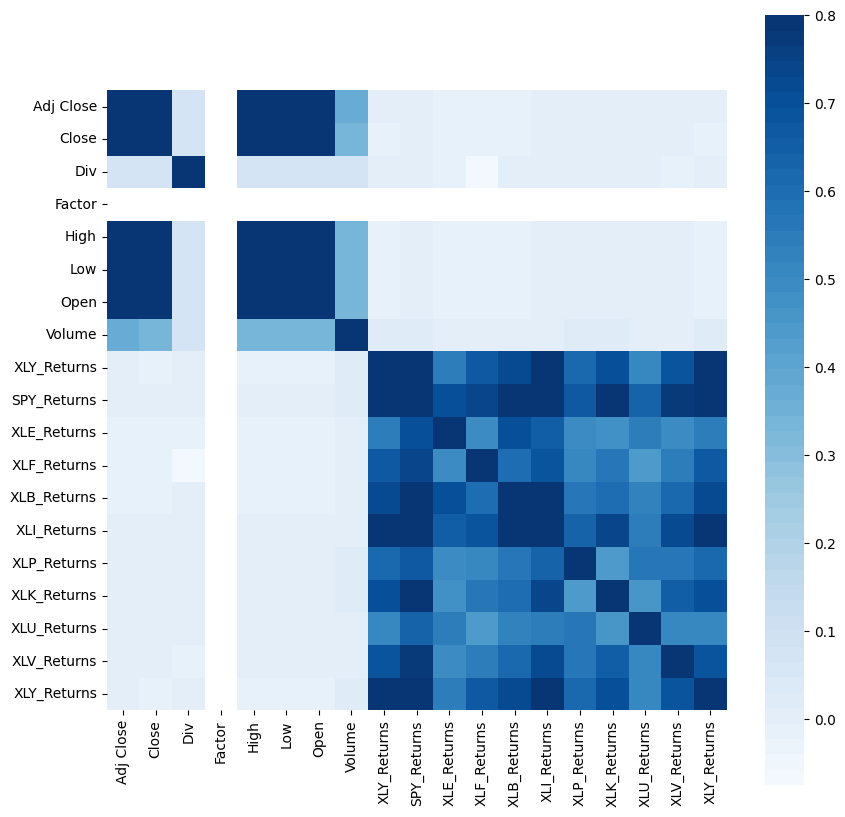

In [240]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


cmap = ListedColormap(sns.color_palette("Blues", n_colors=50))

df = train_data_AAPL.drop(columns='Target_Returns').copy()
if 'Dt' in df.columns:
    df.set_index('Dt', inplace=True)
corrmat = df.corr()

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True,  linecolor='black',cmap=cmap)


There is a high positive correlation between 'High', 'Low', and 'Close' prices with the 'EMA_10' (10-day Exponential Moving Average) and 'EMA_20' (20-day Exponential Moving Average) features. A high positive correlation indicates that these features tend to move in the same direction, meaning that when one of these features increases, the others also tend to increase and vice versa.

On the other hand, there is a very high negative correlation between 'MACD' (Moving Average Convergence Divergence) and 'Midpoint'. A high negative correlation indicates that these features tend to move in the opposite direction, meaning that when one of these features increases, the other tends to decrease and vice versa.



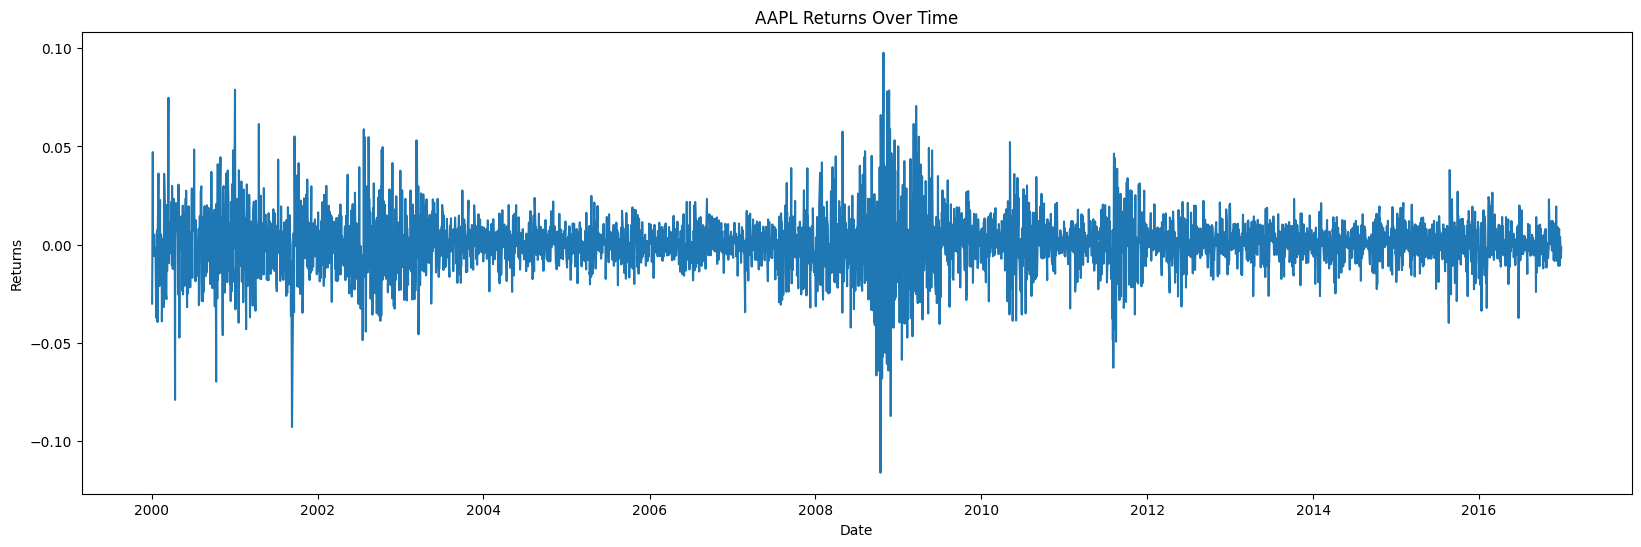

In [241]:
# Plot the returns over time
plt.figure(figsize=(20, 6))
sns.lineplot(data=train_data_AAPL, x=train_data_AAPL.index, y='Target_Returns')
plt.title('AAPL Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

## Feature scaling

The performance of the neural network will be better if the entire training input is in the same range. As we can see from above the stock prices are not in the same range. So, we need to scale the training data such that they are in the same range. This process is called Feature Scaling. The two popular methods for feature scaling are:

* **Standardization**

$ x' = \frac{x - \bar{x}}{\sigma} $

where $ x $ is the original feature vector, $ \bar{x} $ is the mean of that feature vector, and $ \sigma $ is its standard deviation.

* **Normalization** (Min-Max normalization)

$ x' = \frac{x - \text{min}(x)}{\text{max}(x)-\text{min}(x)} $

where $ x $ is an original value, $ x' $ is the normalized value.

It is recommended to use Normalization in the case of RNN networks. Therefore we use Min-Max normalization here. 

In [242]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1)) 

def scale_data(df):
    if 'Dt' in df.columns:
        df.set_index('Dt', inplace=True)

    df_scaled = scaler.fit_transform(df)

    X_train_scaled = df_scaled[:, :-1]

    Y_train_scaled = df_scaled[:,-1]
    Y_train_scaled = Y_train_scaled.reshape(-1, 1)

    return df_scaled, X_train_scaled, Y_train_scaled


The MinMaxScaler scales the values of the DataFrame to a range between 0 and 1. This is done using the fit_transform method of the scaler object, which fits the scaler to the DataFrame and returns a scaled version of the DataFrame. The feature range is set to (0,1) using the feature_range argument.

The scale_data function takes a DataFrame as input, sets the index to the 'Dt' column (if present), scales the input features and target variable using the MinMaxScaler, and returns the scaled input features and target variable in the form of NumPy arrays.

The df_scaled array is obtained by applying the fit_transform method of the scaler object to the input DataFrame.

The X_train_scaled array is obtained by selecting all columns of the df_scaled array except for the last column, which is assumed to be the target variable. This is done using the slicing operator [:, :-1].

The Y_train_scaled array is obtained by selecting only the last column of the df_scaled array. This is done using the slicing operator [:,-1].

The Y_train_scaled array is then reshaped using the reshape method of the array to have a single column. This is done because some machine learning models in scikit-learn require the target variable to be a two-dimensional array with a single column.

Finally, the function returns the X_train_scaled and Y_train_scaled arrays as the scaled input features and target variable, respectively.

In [243]:
train_data_AAPL

Adj Close   Close  Div  Factor     High      Low    Open   
Dt                                                                     
2000-01-03    23.6030  30.125  0.0     1.0  31.0000  29.8590  31.000  \
2000-01-04    22.8930  29.219  0.0     1.0  29.8130  29.0310  29.688   
2000-01-05    22.6114  28.859  0.0     1.0  29.3461  28.7190  29.344   
2000-01-06    22.8685  29.188  0.0     1.0  29.4060  28.9991  29.047   
2000-01-07    23.9458  30.563  0.0     1.0  30.5630  29.5000  29.500   
...               ...     ...  ...     ...      ...      ...     ...   
2016-12-21    80.6102  83.530  0.0     1.0  83.6200  83.3486  83.560   
2016-12-22    79.7416  82.630  0.0     1.0  83.4100  82.4950  83.380   
2016-12-23    79.5679  82.450  0.0     1.0  82.7650  82.3510  82.610   
2016-12-27    79.8767  82.770  0.0     1.0  83.1000  82.5100  82.510   
2016-12-28    79.3267  82.200  0.0     1.0  83.0300  82.1800  82.950   

               Volume  XLY_Returns  SPY_Returns  XLE_Returns  XLF_Returns   
Dt                                                                          
2000-01-03   212900.0    -0.030075    -0.039109    -0.018823    -0.043723  \
2000-01-04   177200.0    -0.012321     0.001789     0.026359    -0.007877   
2000-01-05   124600.0     0.011400    -0.016071     0.038542     0.043925   
2000-01-06   135800.0     0.047108     0.058076     0.010691     0.016580   
2000-01-07    70000.0    -0.005137     0.003431    -0.008334    -0.017657   
...               ...          ...          ...          ...          ...   
2016-12-21  2702800.0    -0.010775    -0.001727     0.004073    -0.002542   
2016-12-22  4461000.0    -0.002178     0.001464    -0.000916     0.001699   
2016-12-23  2837000.0     0.003881     0.002481     0.002227     0.001272   
2016-12-27  6101100.0    -0.006887    -0.008264    -0.010847    -0.010165   
2016-12-28  3857700.0    -0.001338    -0.000223    -0.001982    -0.007274   

            XLB_Returns  XLI_Returns  XLP_Returns  XLK_Returns  XLU_Returns   
Dt                                                                            
2000-01-03    -0.009627    -0.027631    -0.028176    -0.050741    -0.030161  \
2000-01-04     0.041292    -0.004457     0.017685    -0.014841     0.025239   
2000-01-05     0.025690     0.013430     0.018756    -0.033157    -0.001722   
2000-01-06    -0.000582     0.038096     0.063389     0.017456     0.008587   
2000-01-07    -0.003424     0.000000    -0.022441     0.038000     0.003420   
...                 ...          ...          ...          ...          ...   
2016-12-21    -0.004168    -0.001903    -0.001537    -0.002040     0.003509   
2016-12-22     0.001993     0.000953     0.001925     0.001022    -0.000206   
2016-12-23     0.005371     0.002064    -0.000192     0.004084     0.000823   
2016-12-27    -0.010091    -0.010456    -0.006148    -0.008949    -0.009455   
2016-12-28     0.000000    -0.000320     0.004639     0.000205     0.013488   

            XLV_Returns  XLY_Returns  Target_Returns  
Dt                                                    
2000-01-03    -0.022709    -0.030075       -0.030075  
2000-01-04    -0.008950    -0.012321       -0.012321  
2000-01-05     0.003203     0.011400        0.011400  
2000-01-06     0.012195     0.047108        0.047108  
2000-01-07     0.102259    -0.005137       -0.005137  
...                 ...          ...             ...  
2016-12-21     0.001307    -0.010775       -0.010775  
2016-12-22     0.007543    -0.002178       -0.002178  
2016-12-23     0.002016     0.003881        0.003881  
2016-12-27    -0.007615    -0.006887       -0.006887  
2016-12-28     0.001737    -0.001338       -0.001338  

[4275 rows x 20 columns]

In [244]:
train_data_AAPL.shape

(4275, 20)

In [245]:
for ticker in ticker_list:
    exec(f'train_{ticker}_scaled, X_train_{ticker}_scaled, Y_train_{ticker}_scaled = scale_data(train_data_{ticker})')
    exec(f'test_{ticker}_scaled, X_test_{ticker}_scaled, Y_test_{ticker}_scaled = scale_data(test_data_{ticker})')

In [246]:
train_AAPL_scaled.shape

(4275, 20)

In [247]:
test_AAPL_scaled.shape

(249, 20)

In [248]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def plot_pca_expl_var(pca):
    """Plot the explained variance of each principal component and the cumulative explained variance."""
    n_components = len(pca.explained_variance_ratio_)
    component_indices = np.arange(n_components)
    explained_variance_ratios = 100 * pca.explained_variance_ratio_

    fig, ax = plt.subplots(figsize=(25, 6))
    cumulative_variances = np.cumsum(explained_variance_ratios)
    ax.bar(component_indices, explained_variance_ratios)
    ax.plot(component_indices, cumulative_variances)
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    ax.set_title('Explained Variance (EV) for Every Principal Component')
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    plt.show()

In [249]:
train_data_AAPL

Adj Close   Close  Div  Factor     High      Low    Open   
Dt                                                                     
2000-01-03    23.6030  30.125  0.0     1.0  31.0000  29.8590  31.000  \
2000-01-04    22.8930  29.219  0.0     1.0  29.8130  29.0310  29.688   
2000-01-05    22.6114  28.859  0.0     1.0  29.3461  28.7190  29.344   
2000-01-06    22.8685  29.188  0.0     1.0  29.4060  28.9991  29.047   
2000-01-07    23.9458  30.563  0.0     1.0  30.5630  29.5000  29.500   
...               ...     ...  ...     ...      ...      ...     ...   
2016-12-21    80.6102  83.530  0.0     1.0  83.6200  83.3486  83.560   
2016-12-22    79.7416  82.630  0.0     1.0  83.4100  82.4950  83.380   
2016-12-23    79.5679  82.450  0.0     1.0  82.7650  82.3510  82.610   
2016-12-27    79.8767  82.770  0.0     1.0  83.1000  82.5100  82.510   
2016-12-28    79.3267  82.200  0.0     1.0  83.0300  82.1800  82.950   

               Volume  XLY_Returns  SPY_Returns  XLE_Returns  XLF_Returns   
Dt                                                                          
2000-01-03   212900.0    -0.030075    -0.039109    -0.018823    -0.043723  \
2000-01-04   177200.0    -0.012321     0.001789     0.026359    -0.007877   
2000-01-05   124600.0     0.011400    -0.016071     0.038542     0.043925   
2000-01-06   135800.0     0.047108     0.058076     0.010691     0.016580   
2000-01-07    70000.0    -0.005137     0.003431    -0.008334    -0.017657   
...               ...          ...          ...          ...          ...   
2016-12-21  2702800.0    -0.010775    -0.001727     0.004073    -0.002542   
2016-12-22  4461000.0    -0.002178     0.001464    -0.000916     0.001699   
2016-12-23  2837000.0     0.003881     0.002481     0.002227     0.001272   
2016-12-27  6101100.0    -0.006887    -0.008264    -0.010847    -0.010165   
2016-12-28  3857700.0    -0.001338    -0.000223    -0.001982    -0.007274   

            XLB_Returns  XLI_Returns  XLP_Returns  XLK_Returns  XLU_Returns   
Dt                                                                            
2000-01-03    -0.009627    -0.027631    -0.028176    -0.050741    -0.030161  \
2000-01-04     0.041292    -0.004457     0.017685    -0.014841     0.025239   
2000-01-05     0.025690     0.013430     0.018756    -0.033157    -0.001722   
2000-01-06    -0.000582     0.038096     0.063389     0.017456     0.008587   
2000-01-07    -0.003424     0.000000    -0.022441     0.038000     0.003420   
...                 ...          ...          ...          ...          ...   
2016-12-21    -0.004168    -0.001903    -0.001537    -0.002040     0.003509   
2016-12-22     0.001993     0.000953     0.001925     0.001022    -0.000206   
2016-12-23     0.005371     0.002064    -0.000192     0.004084     0.000823   
2016-12-27    -0.010091    -0.010456    -0.006148    -0.008949    -0.009455   
2016-12-28     0.000000    -0.000320     0.004639     0.000205     0.013488   

            XLV_Returns  XLY_Returns  Target_Returns  
Dt                                                    
2000-01-03    -0.022709    -0.030075       -0.030075  
2000-01-04    -0.008950    -0.012321       -0.012321  
2000-01-05     0.003203     0.011400        0.011400  
2000-01-06     0.012195     0.047108        0.047108  
2000-01-07     0.102259    -0.005137       -0.005137  
...                 ...          ...             ...  
2016-12-21     0.001307    -0.010775       -0.010775  
2016-12-22     0.007543    -0.002178       -0.002178  
2016-12-23     0.002016     0.003881        0.003881  
2016-12-27    -0.007615    -0.006887       -0.006887  
2016-12-28     0.001737    -0.001338       -0.001338  

[4275 rows x 20 columns]

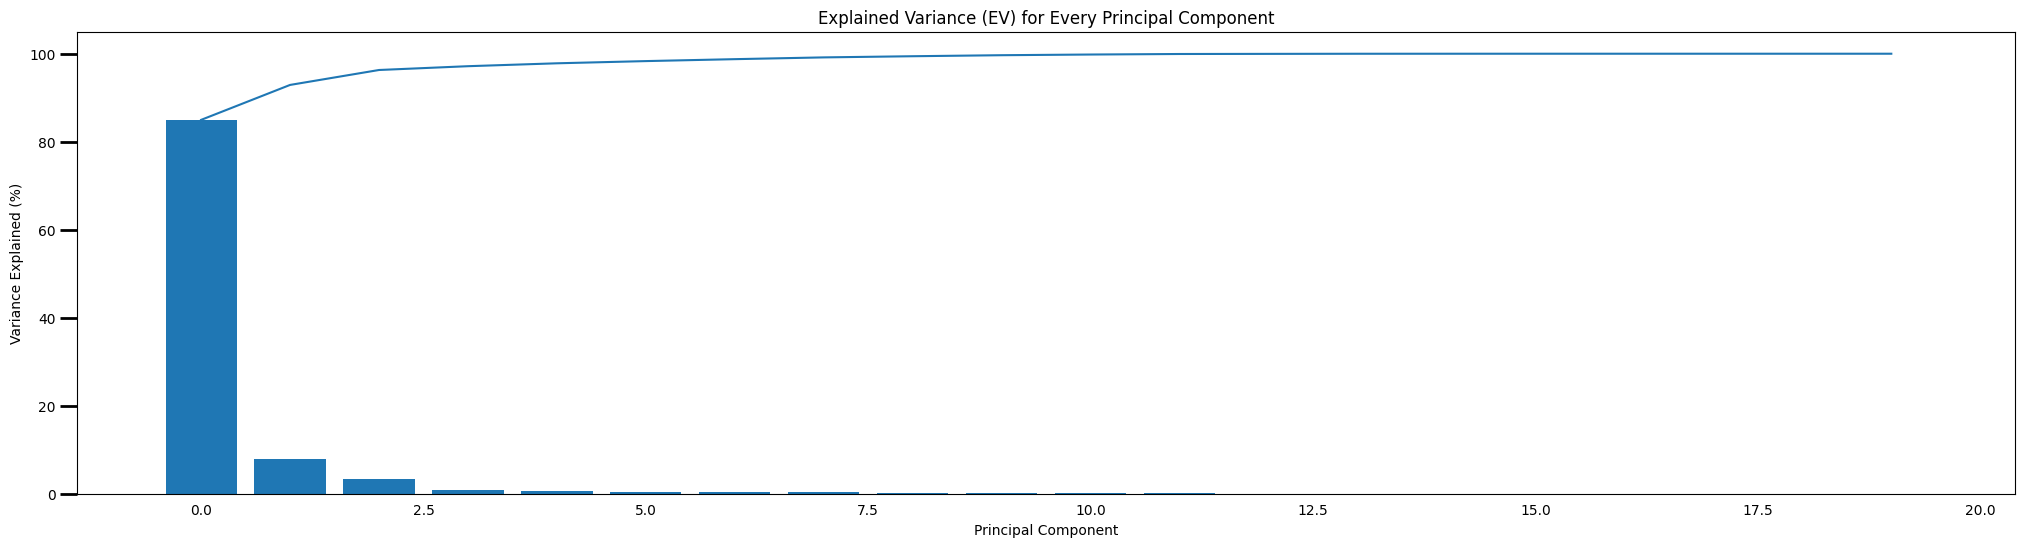

20 components have cumulative explained variance of: 0.9999999999999998
13 components have cumulative explained variance of: 0.9996616376532439
2 components have cumulative explained variance of: 0.9290714741040249


In [250]:
pca = PCA(n_components=20)
scaler_ = MinMaxScaler(feature_range = (0,1)) 
X_train_pca = pca.fit_transform(scaler_.fit_transform(train_data_AAPL))
plot_pca_expl_var(pca)

#pca_plt_explainvar(X_train, n_components=20)
    
n_components = 20
print(f'{n_components} components have cumulative explained variance of: {sum(pca.explained_variance_ratio_[:n_components])}')
n_components = 13
print(f'{n_components} components have cumulative explained variance of: {sum(pca.explained_variance_ratio_[:n_components])}')
n_components = 2
print(f'{n_components} components have cumulative explained variance of: {sum(pca.explained_variance_ratio_[:n_components])}')

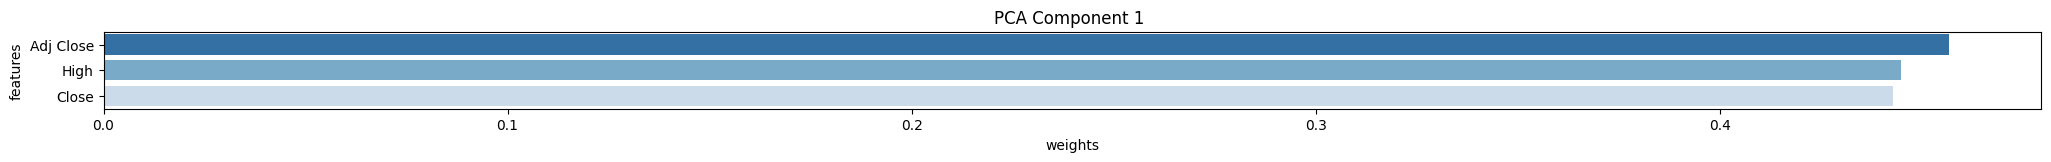

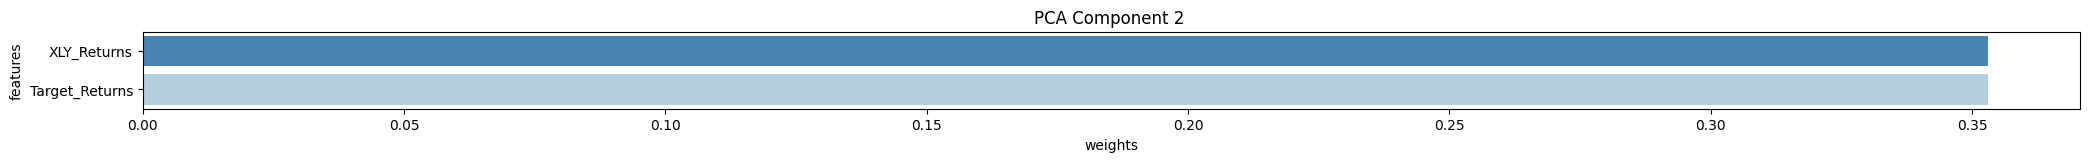

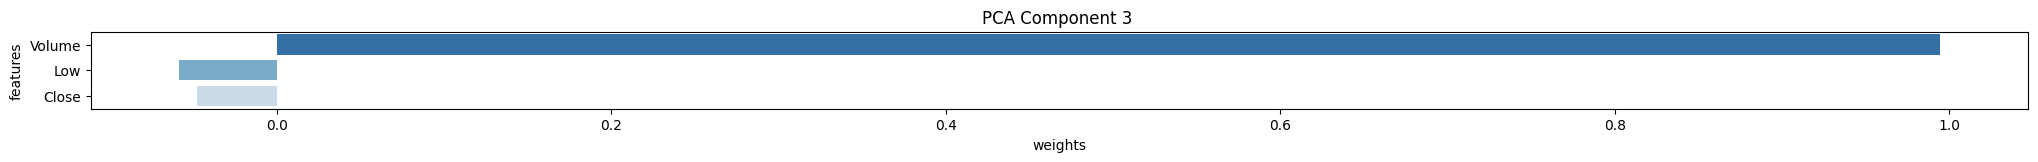

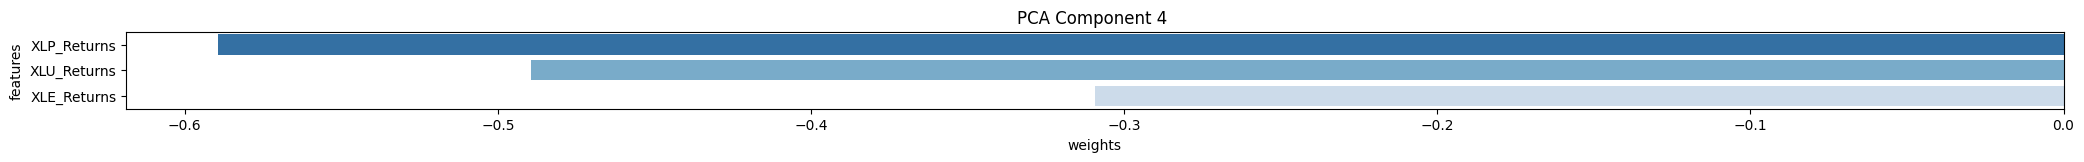

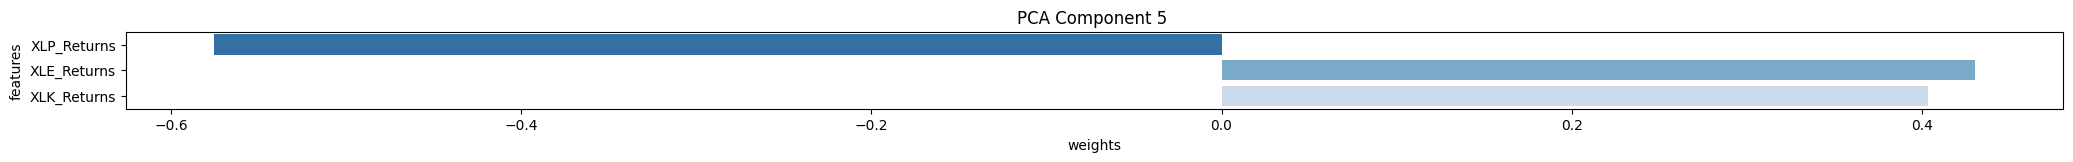

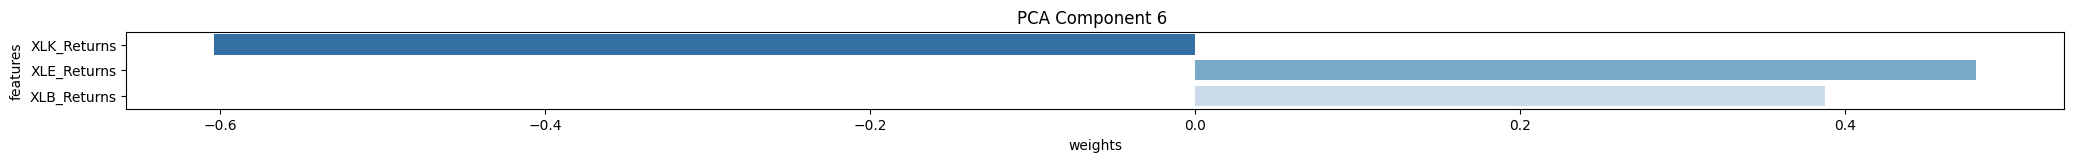

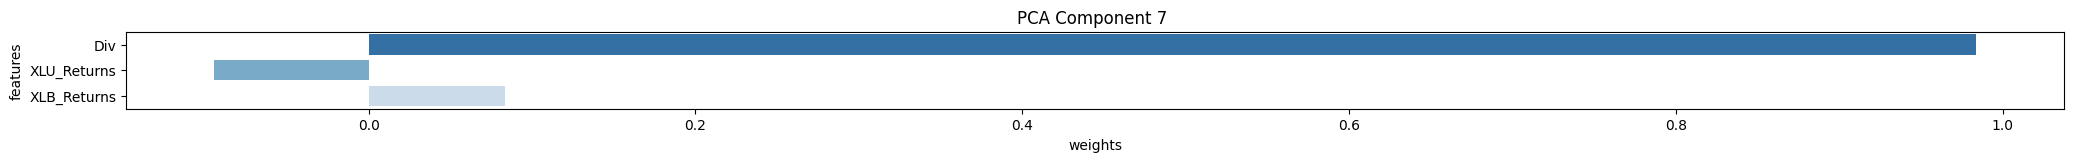

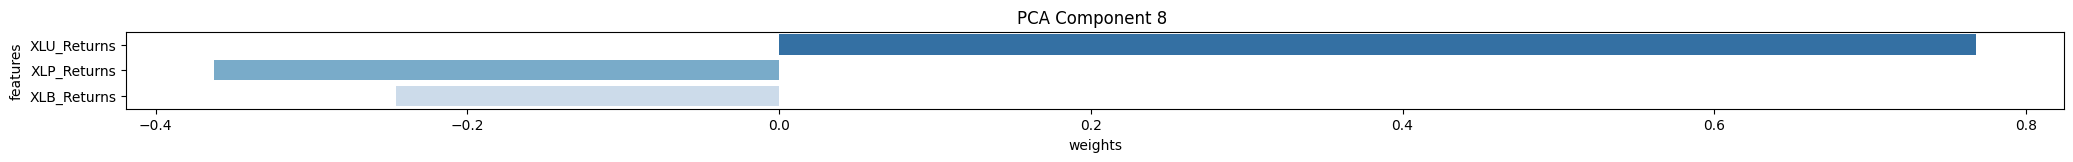

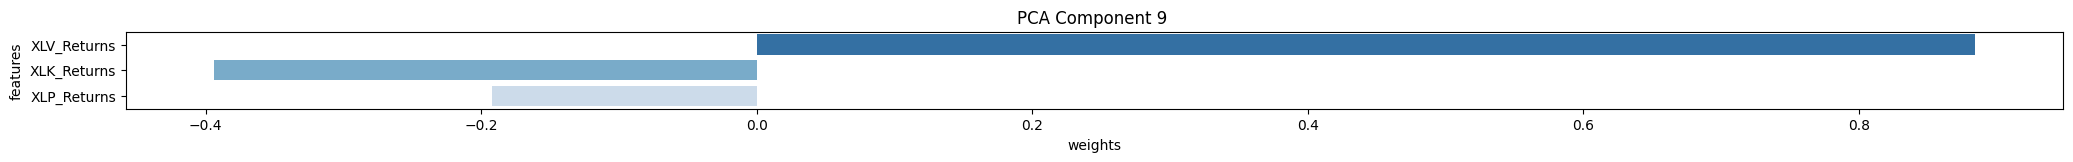

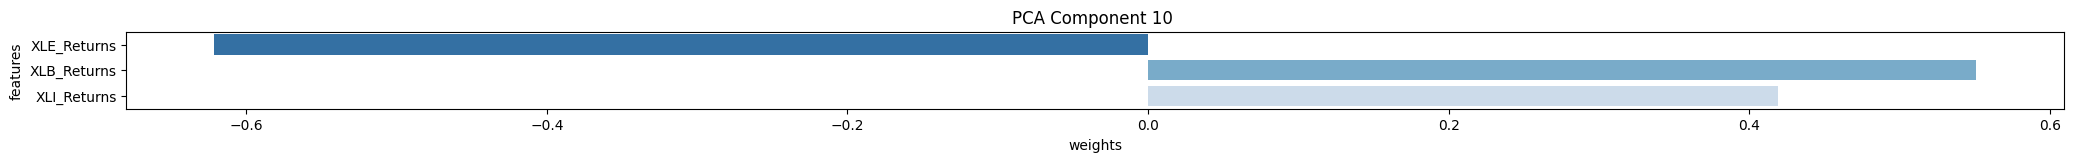

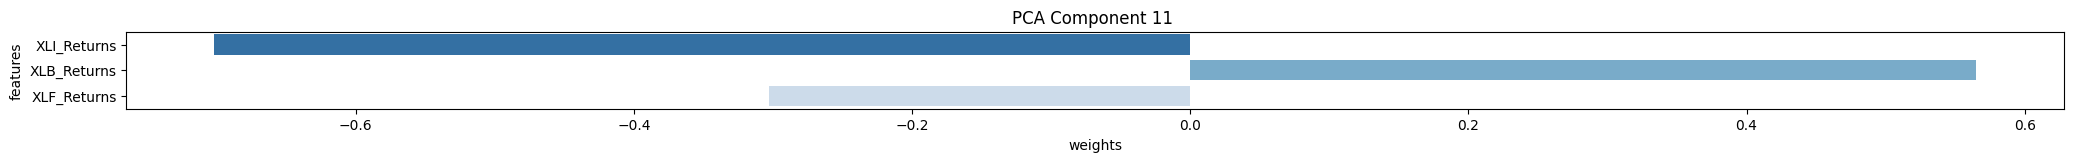

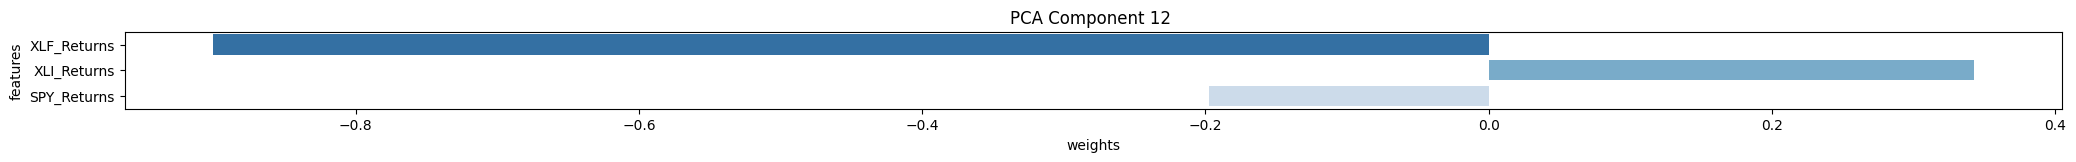

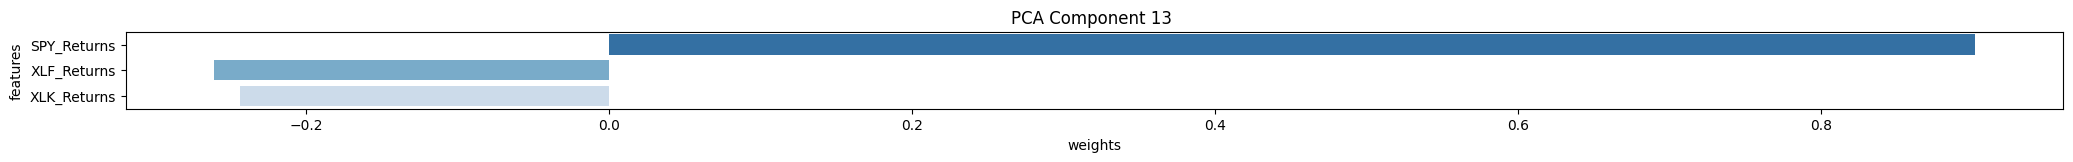

The top 3 features underlying each of the first 13 PCA components are: Adj Close, Close, Div, High, Low, SPY_Returns, Target_Returns, Volume, XLB_Returns, XLE_Returns, XLF_Returns, XLI_Returns, XLK_Returns, XLP_Returns, XLU_Returns, XLV_Returns, XLY_Returns


In [251]:
def plot_pca_component(v, feature_names, component_num, n_weights=10):
    """Visualize the top contributing features for a given PCA component."""
    # Get the weights for the specified component
    component_weights = v[component_num - 1]
    component_weights = np.squeeze(component_weights)

    # Sort features by absolute weight magnitude
    feature_weights = list(zip(component_weights, feature_names))
    feature_weights = pd.DataFrame(feature_weights, columns=['weights', 'features'])
    feature_weights['abs_weights'] = np.abs(feature_weights['weights'])
    feature_weights = feature_weights.sort_values('abs_weights', ascending=False).head(n_weights)

    # Plot the feature weights using seaborn
    fig, ax = plt.subplots(figsize=(25, 1))
    sns.barplot(data=feature_weights, x="weights", y="features", palette="Blues_r", ax=ax)
    ax.set_title(f"PCA Component {component_num} ")
    plt.show()

    return feature_weights['features'].values.tolist()


top_features = []
for component_num in range(1, 14):
    top_features.extend(plot_pca_component(pca.components_, train_data_AAPL[:-1].columns.values, component_num=component_num, n_weights=3))

top_features = np.array(top_features).flatten()
print(f"The top 3 features underlying each of the first 13 PCA components are: {', '.join(np.unique(top_features))}")


In [252]:
X_train_AAPL_scaled.shape

(4275, 19)

## LSTM

LSTM stands for Long Short-Term Memory, and it is a type of recurrent neural network (RNN) architecture that is particularly useful for processing sequential data.

At its core, an LSTM network consists of a series of interconnected memory blocks, or cells. Each cell has three gates: the input gate, the forget gate, and the output gate. These gates regulate the flow of information in and out of the cell.

When the LSTM network is fed a sequence of inputs, the input gate determines which parts of the input should be allowed into the cell, and the forget gate determines which parts of the cell's current state should be preserved or discarded. The output gate then determines which parts of the cell's current state should be passed to the output.

The LSTM architecture allows the network to selectively remember or forget information from the past, making it particularly useful for processing long sequences of data. It also allows for the flow of information to be regulated based on the current input, so that the network can adapt to changing patterns in the data.

During training, the weights of the LSTM network are adjusted using backpropagation through time (BPTT), which involves computing gradients of the loss function with respect to the network's parameters and using them to update the weights using an optimization algorithm. The goal of training is to learn a set of weights that allow the network to accurately predict the output for a given input sequence.

In [253]:
def prepare_lstm_data(X_train_scaled, Y_train_scaled, backcandles=20):
    X = []
    
    backcandles = 20
    for j in range(19):
        X.append([])
        for i in range(backcandles, X_train_scaled.shape[0]):
            X[j].append(X_train_scaled[i-backcandles:i, j])

    #move axis from 0 to position 2
    X=np.moveaxis(X, [0], [2])


    X, yi =np.array(X), np.array(Y_train_scaled[backcandles:,0])
    y=np.reshape(yi,(len(yi),1))
    
    return X, y

The prepare_lstm_data function prepares the input data for training an LSTM model for a time-series forecasting task. The function takes three arguments: X_train_scaled, Y_train_scaled, and backcandles.

The input feature array X_train_scaled and the target variable array Y_train_scaled are obtained from the scale_data function, and contain the scaled input features and target variable, respectively.

The backcandles parameter is used to specify the number of previous time steps that the LSTM model should consider when making a prediction. This parameter sets the length of the sliding window over the time series data.

The function first creates an empty list X, and then creates a 3-dimensional array of shape (n_samples, backcandles, n_features) by sliding the window over the input data.



The first loop of the function iterates over the 14 input features, and appends an empty list to X for each feature.

The second loop of the function slides the window over the input data, and appends a slice of the data of length backcandles to the corresponding feature list in X.

The resulting X list is then converted to a NumPy array using the np.array function, and the axis is moved from position 0 to position 2 using the np.moveaxis function. This creates a 3-dimensional array of shape (n_samples, backcandles, n_features) that can be used as input to the LSTM model.

The target variable array Y_train_scaled is sliced to exclude the first backcandles time steps, as these do not have enough history to be used as input to the LSTM model. The resulting array yi is reshaped to have a single column using the np.reshape function.

Finally, the function returns the input feature array X and the target variable array y as NumPy arrays. These arrays can be used to train an LSTM model for time-series forecasting.

In [254]:
for ticker in ticker_list:
    exec(f'X_train_lstm_{ticker}, Y_train_lstm_{ticker} = prepare_lstm_data(X_train_{ticker}_scaled, Y_train_{ticker}_scaled)')
    exec(f'X_test_lstm_{ticker}, Y_test_lstm_{ticker} = prepare_lstm_data(X_test_{ticker}_scaled, Y_test_{ticker}_scaled)')


In [255]:
X_test_lstm_AAPL.shape

(229, 20, 19)

# Performance metrics
$R^2$ is a statistical measure that indicates how well the model fits the data by representing the proportion of variance in the dependent variable that is explained by the independent variables. A higher $R^2$ value indicates a better fit of the model to the data.

MSE, MAE, and RMSE all measure the distance between the predicted values and the actual values, but in slightly different ways. MSE is the average of the squared differences between the predicted and actual values, MAE is the average of the absolute differences, and RMSE is the square root of the MSE, representing the standard deviation of the errors.

When evaluating stock prediction models, there is no one "best" performance measure, as the choice depends on the specific problem and the intended use of the model. For example, $R^2$ might be useful for comparing different models, while RMSE might be more appropriate for setting thresholds for decision-making.

Considering that we are working with multiple models, we will evaluate their performance using all four metrics, but will use $R^2$ as the primary metric for selecting the final model. However, it is important to consider other factors such as the data quality and the nature of the problem in addition to the evaluation metrics.

# Creating, testing and evaluating models


For the purpose of returns prediction I will be using LSTM.
LSTM is particularly suitable for predicting returns because it is designed to handle sequential data with long-term dependencies. When predicting returns, it is often important to consider past price movements and market trends, which can extend over many time steps. LSTM is able to capture these long-term dependencies by selectively retaining and updating information in its memory cells.

Compared to other neural network models, such as feedforward networks or traditional RNNs, LSTM is able to handle longer input sequences and retain more information over time. This makes it well-suited for tasks such as predicting financial returns, where the relationship between past and future observations may not be immediately apparent.

In addition, LSTM is able to learn more complex patterns in the data by selectively retaining or discarding information at each time step. This allows it to capture both short-term and long-term patterns in the data, which may be useful for predicting returns in financial markets.



In [256]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np



# Model 1

- Single layer
- Activation - Relu
- loss - mean_squared_error
- optimizer -'adam'

In [257]:
X_train_lstm_AAPL.shape

(4255, 20, 19)

In [258]:
model_name0 = "LSTM_1"
max_epochs = 10

def create_lstm_model1(X_train, y_train, backcandles=20, batch_size=15, epochs=10):
    np.random.seed(10)
    model = Sequential([
        LSTM(150, input_shape=(backcandles, 19), name='first_layer'),
        Dense(1, name='dense_layer'),
        Activation('relu', name='output')
    ])
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss='mean_squared_error')
    history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, validation_split=0.1)
    return model, history


# AAPL

Epoch 1/10
256/256 [==============================] - 3s 9ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 2/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 3/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 4/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 5/10
256/256 [==============================] - 2s 9ms/step - loss: 0.0050 - val_loss: 0.0028
Epoch 6/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 7/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 8/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 9/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0049 - val_loss: 0.0022
Epoch 10/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0050 - val_loss: 0.0025

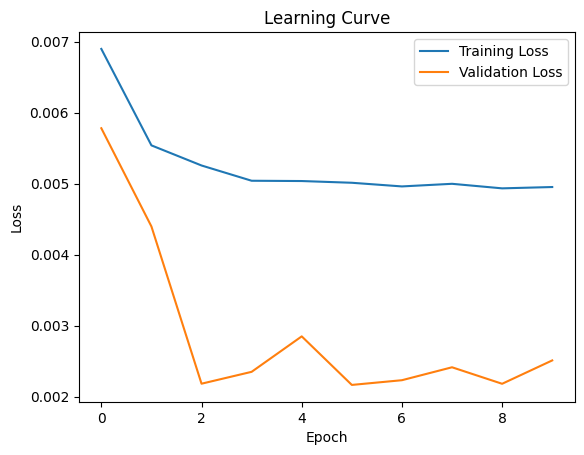

In [259]:
model_and_history = create_lstm_model1(X_train_lstm_AAPL, Y_train_lstm_AAPL)
model1 = model_and_history
history1 = model_and_history[1]
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [260]:
def print_predictions(model, X_test, y_test, test_scaled):
    y_pred = model[0].predict(X_test)
    # for i in range(20):
    #     print(y_pred[i], y_test[i+20])
    
    y_test = y_test[20:]
    test_scaled = test_scaled[20:]

    # Extract the y_test_AAPL_scaled
    y_test_scaled = y_test
    y_pred_scaled = y_pred

    pred_scaled = np.copy(test_scaled)

    pred_scaled[:, -1] = y_pred_scaled.reshape(-1)

    test_scaled[:, -1] = y_test_scaled.reshape(-1)

    # print(test_scaled[:, -1])
    # print(pred_scaled[:, -1])

    # Invert the scaling for the entire test_AAPL_scaled
    test_inverted = scaler.inverse_transform(test_scaled)
    pred_inverted = scaler.inverse_transform(pred_scaled)

    # Extract the inverted 'Return' column
    y_test_inverted = test_inverted[:, -1].reshape(-1)
    y_pred_inverted = pred_inverted[:, -1].reshape(-1)


    # for i in range(10):
    #     print(y_pred_inverted[i], y_test_inverted[i])
    return y_test_inverted , y_pred_inverted


## TRAIN

133/133 [==============================] - 0s 3ms/step


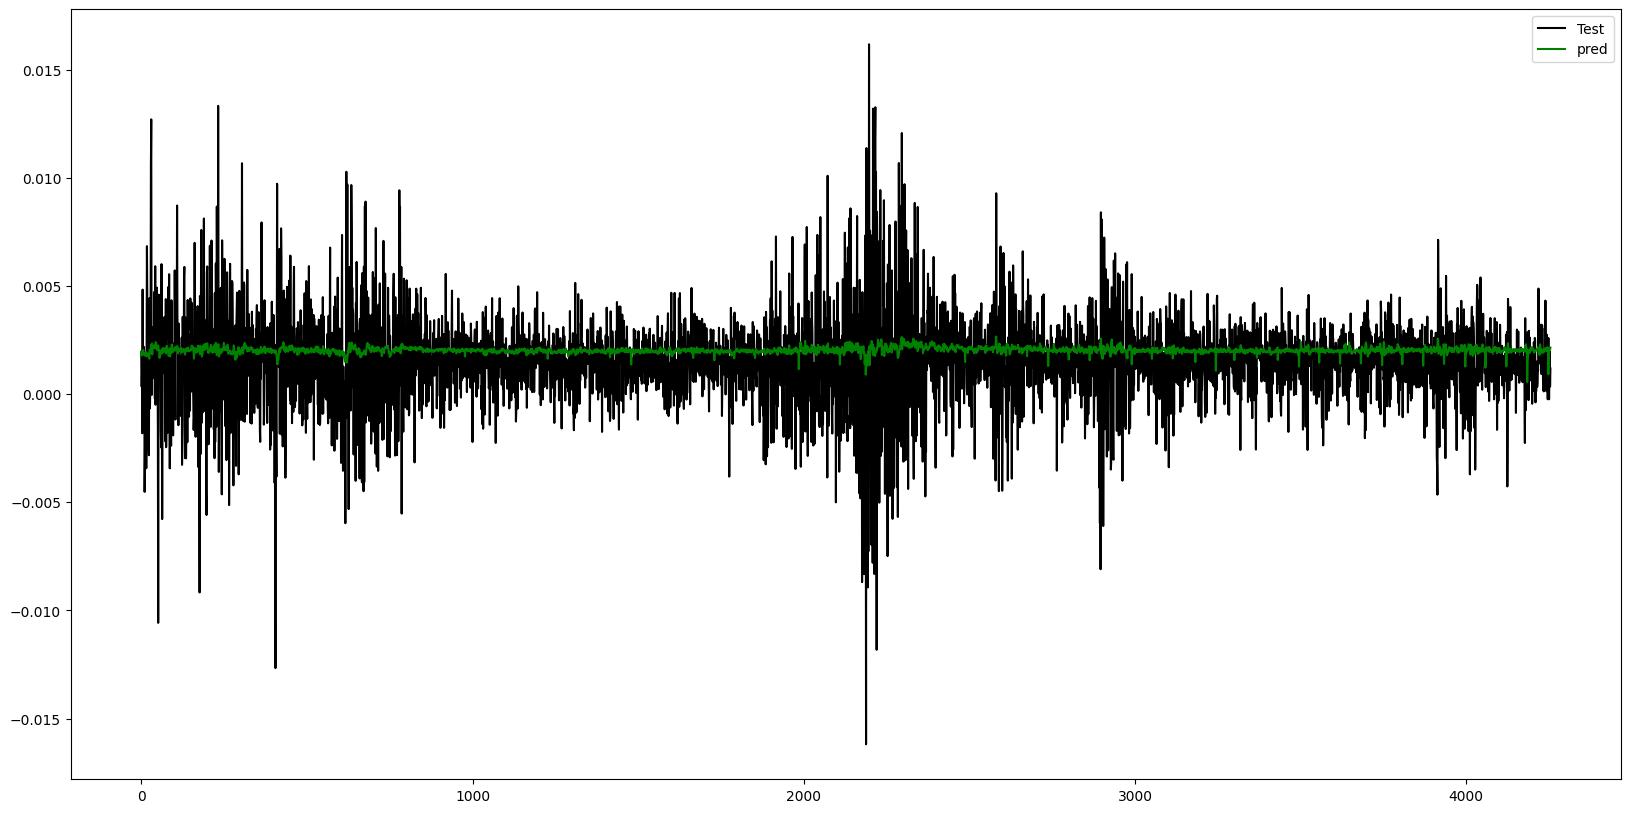

In [261]:
for ticker in ticker_list:
    y_train_AAPL , y_pred_AAPL = print_predictions(model1, X_train_lstm_AAPL,  Y_train_AAPL_scaled, train_AAPL_scaled)

plt.figure(figsize=(20,10))
plt.plot(y_train_AAPL, color = 'black', label = 'Test')
plt.plot(y_pred_AAPL, color = 'green', label = 'pred')
plt.legend()
plt.show()

## TEST

8/8 [==============================] - 0s 3ms/step


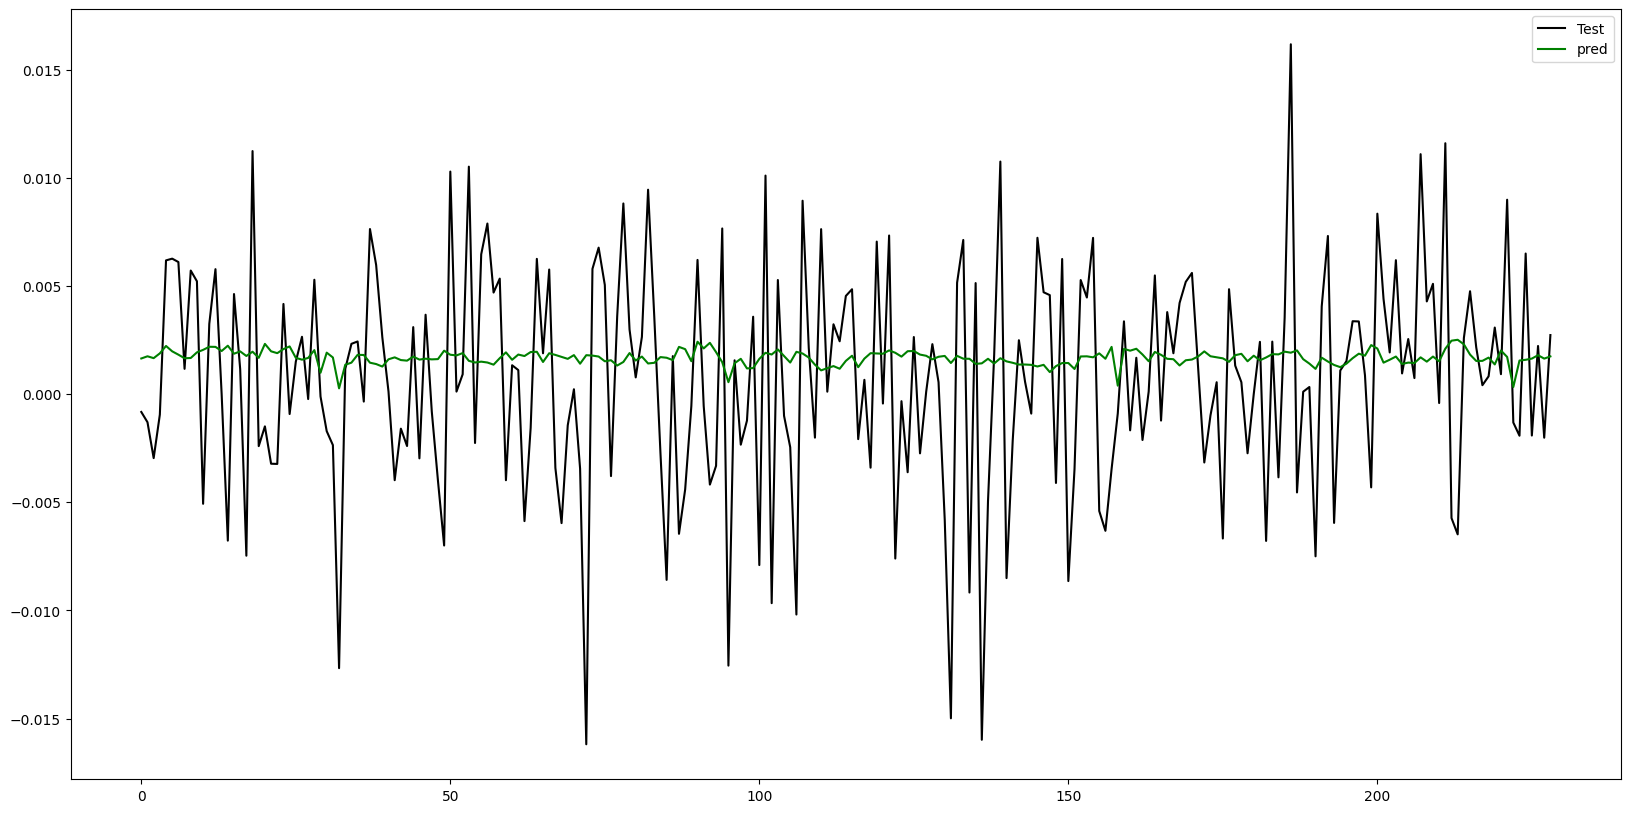

mse: 2.7806198802680153e-05
rmse: 0.005273158332790715
mae: 0.004106970930991778
r_square: -0.03131803494604379


In [262]:
for ticker in ticker_list:
    y_test_AAPL , y_pred_AAPL = print_predictions(model1, X_test_lstm_AAPL,  Y_test_AAPL_scaled, test_AAPL_scaled)
    
plt.figure(figsize=(20,10))
plt.plot(y_test_AAPL, color = 'black', label = 'Test')
plt.plot(y_pred_AAPL, color = 'green', label = 'pred')
plt.legend()
plt.show()

# calculate MSE 
mse=mean_squared_error(y_test_AAPL, y_pred_AAPL)
# calculate RMSE 
rmse = math.sqrt(mean_squared_error(y_test_AAPL, y_pred_AAPL))
# calculate MAE 
mae = mean_absolute_error(y_test_AAPL, y_pred_AAPL)
# calculate R square
r_square=r2_score(y_test_AAPL, y_pred_AAPL)

print("mse: " + str(mse))
print("rmse: " + str(rmse))
print("mae: " + str(mae))
print("r_square: " + str(r_square))


relu performs bad, we can see the predicted returns much lower than actual returns

# Model 2 

- Model 2 : Increase Epochs size
- Single layer
- Activation - Relu
- loss - mean_squared_error
- optimizer -'adam'

In [263]:
model_name0 = "LSTM_2"
max_epochs = 10

def create_lstm_model2(X_train, y_train, backcandles=20, batch_size=15, epochs=20):
    np.random.seed(10)
    model = Sequential([
        LSTM(150, input_shape=(backcandles, 19), name='first_layer'),
        Dense(1, name='dense_layer'),
        Activation('relu', name='output')
    ])
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss='mean_squared_error')
    history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, validation_split=0.1)
    return model, history


Epoch 1/20
256/256 [==============================] - 3s 9ms/step - loss: 0.3017 - val_loss: 0.2983
Epoch 2/20
256/256 [==============================] - 2s 8ms/step - loss: 0.3017 - val_loss: 0.2983
Epoch 3/20
256/256 [==============================] - 2s 8ms/step - loss: 0.3017 - val_loss: 0.2983
Epoch 4/20
256/256 [==============================] - 2s 8ms/step - loss: 0.3017 - val_loss: 0.2983
Epoch 5/20
256/256 [==============================] - 2s 8ms/step - loss: 0.3017 - val_loss: 0.2983
Epoch 6/20
256/256 [==============================] - 2s 8ms/step - loss: 0.3017 - val_loss: 0.2983
Epoch 7/20
256/256 [==============================] - 2s 9ms/step - loss: 0.3017 - val_loss: 0.2983
Epoch 8/20
256/256 [==============================] - 2s 8ms/step - loss: 0.3017 - val_loss: 0.2983
Epoch 9/20
256/256 [==============================] - 2s 9ms/step - loss: 0.3017 - val_loss: 0.2983
Epoch 10/20
256/256 [==============================] - 2s 8ms/step - loss: 0.3017 - val_loss: 0.2983

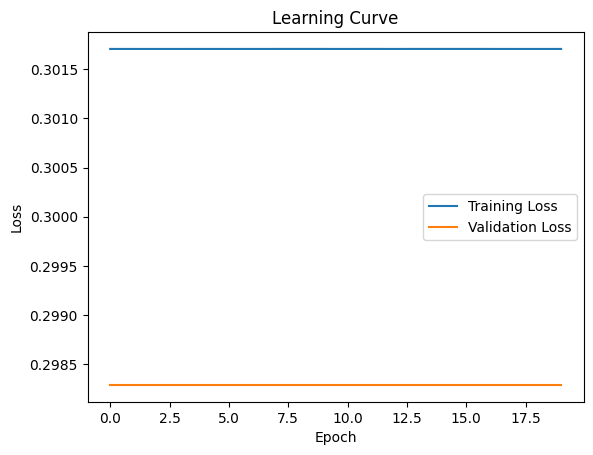

In [264]:
model_and_history = create_lstm_model2(X_train_lstm_AAPL, Y_train_lstm_AAPL)
model2 = model_and_history
history2 = model_and_history[1]
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## TRAIN

133/133 [==============================] - 0s 3ms/step


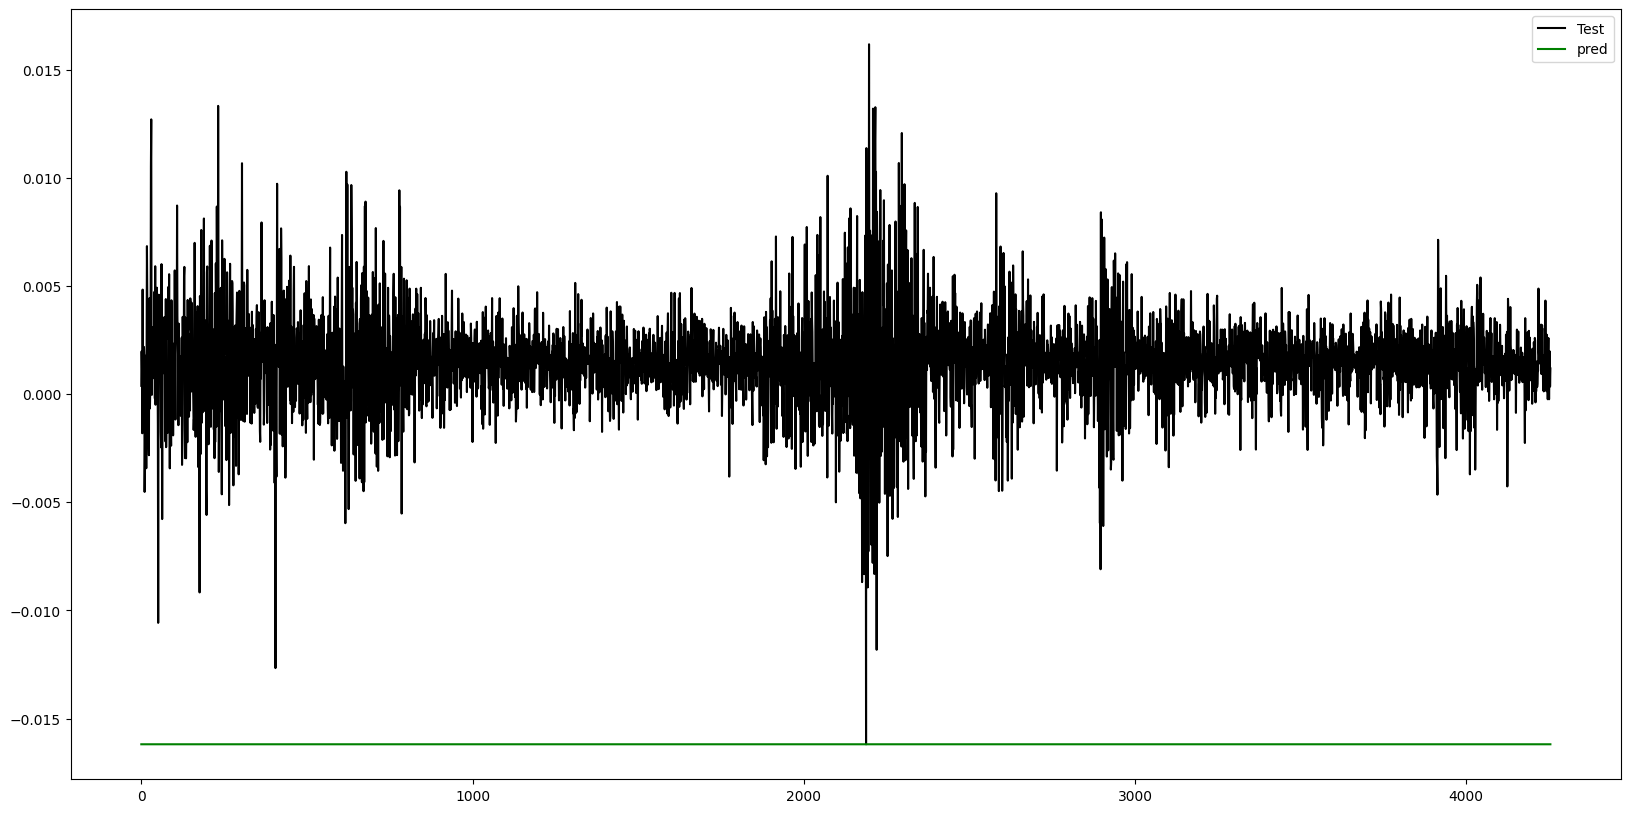

In [265]:
for ticker in ticker_list:
    y_train_AAPL , y_pred_AAPL = print_predictions(model2, X_train_lstm_AAPL,  Y_train_AAPL_scaled, train_AAPL_scaled)
    
plt.figure(figsize=(20,10))
plt.plot(y_train_AAPL, color = 'black', label = 'Test')
plt.plot(y_pred_AAPL, color = 'green', label = 'pred')
plt.legend()
plt.show()

## TEST

8/8 [==============================] - 0s 3ms/step


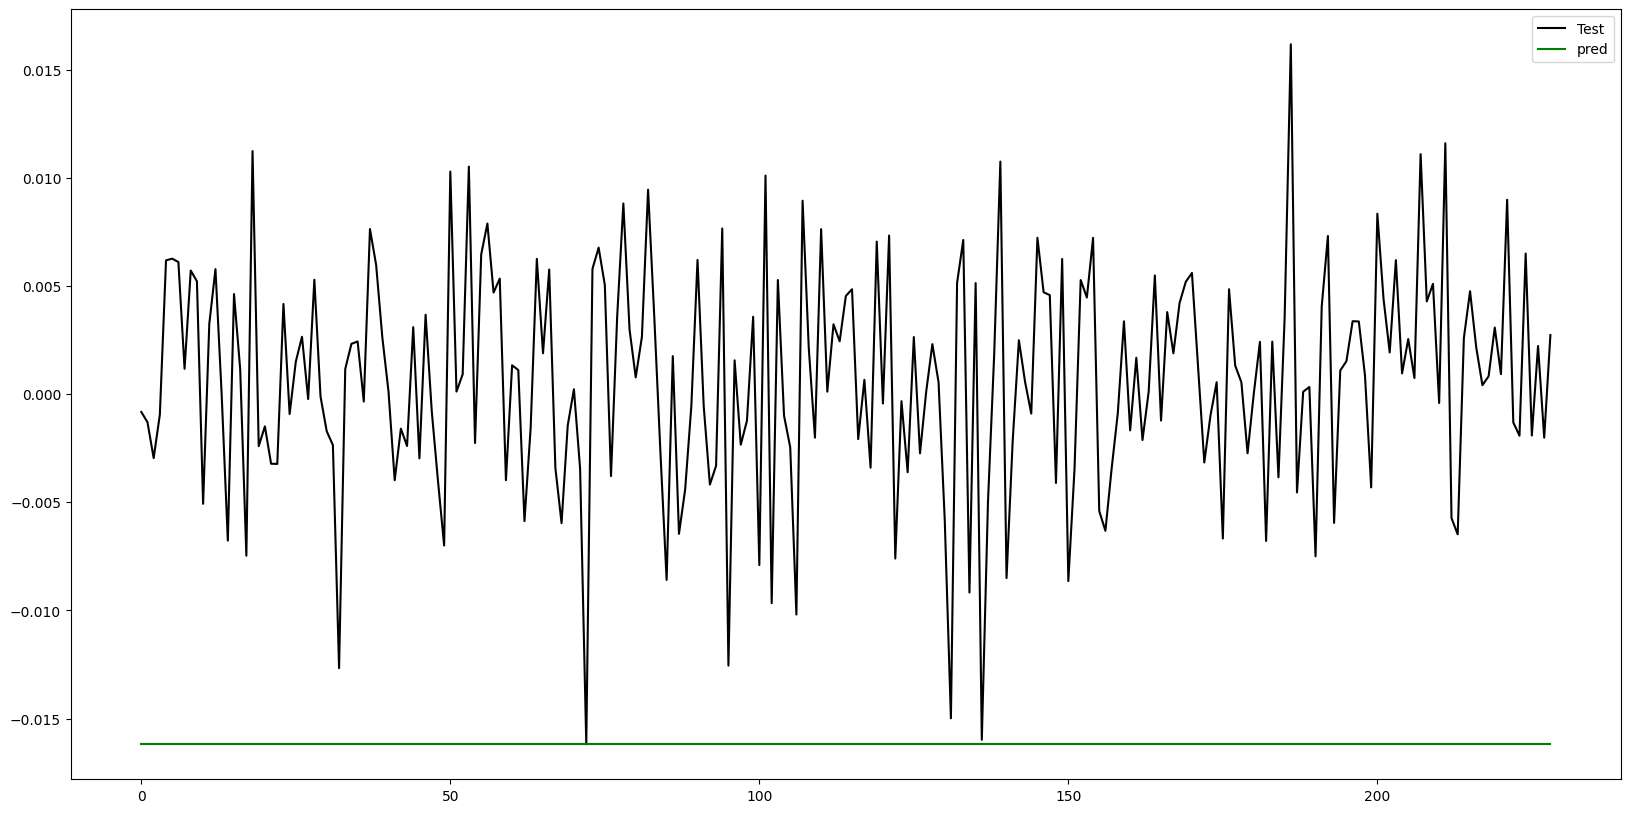

mse: 0.0003123438494841654
rmse: 0.017673252374256567
mae: 0.016893254320152408
r_square: -10.584677480132365


In [266]:
for ticker in ticker_list:
    y_test_AAPL , y_pred_AAPL = print_predictions(model2, X_test_lstm_AAPL,  Y_test_AAPL_scaled, test_AAPL_scaled)
    
plt.figure(figsize=(20,10))
plt.plot(y_test_AAPL, color = 'black', label = 'Test')
plt.plot(y_pred_AAPL, color = 'green', label = 'pred')
plt.legend()
plt.show()

# calculate MSE 
mse=mean_squared_error(y_test_AAPL, y_pred_AAPL)
# calculate RMSE 
rmse = math.sqrt(mean_squared_error(y_test_AAPL, y_pred_AAPL))
# calculate MAE 
mae = mean_absolute_error(y_test_AAPL, y_pred_AAPL)
# calculate R square
r_square=r2_score(y_test_AAPL, y_pred_AAPL)

print("mse: " + str(mse))
print("rmse: " + str(rmse))
print("mae: " + str(mae))
print("r_square: " + str(r_square))

# Model 3

- Model 3 : Tanh
- Single layer
- Activation - Tanh
- loss - mean_squared_error
- optimizer -'adam'

In [267]:
def create_lstm_model3(X_train, y_train, backcandles=20, batch_size=15, epochs=10):
    np.random.seed(10)
    model = Sequential([
        LSTM(150, input_shape=(backcandles, 19), name='first_layer'),
        Dense(1, name='dense_layer'),
        Activation('tanh', name='output')
    ])
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss='mean_squared_error')
    history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, validation_split=0.1)
    return model, history


Epoch 1/10
256/256 [==============================] - 3s 9ms/step - loss: 0.0084 - val_loss: 0.0036
Epoch 2/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0052 - val_loss: 0.0023
Epoch 3/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 4/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0051 - val_loss: 0.0026
Epoch 5/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0051 - val_loss: 0.0027
Epoch 6/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 7/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 8/10
256/256 [==============================] - 2s 9ms/step - loss: 0.0049 - val_loss: 0.0022
Epoch 9/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 10/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0050 - val_loss: 0.0026

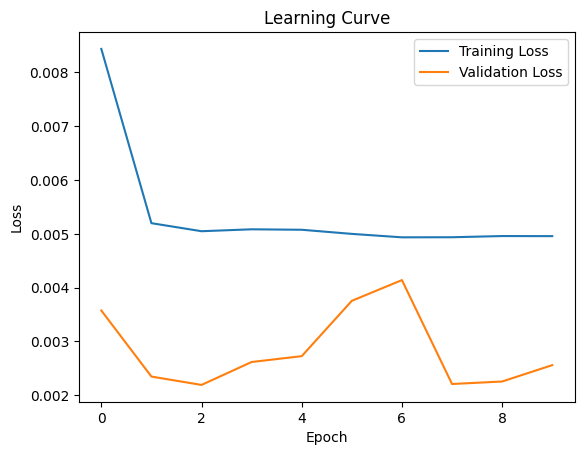

In [268]:
model_and_history = create_lstm_model3(X_train_lstm_AAPL, Y_train_lstm_AAPL)
model3 = model_and_history
history3 = model_and_history[1]
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## TRAIN

133/133 [==============================] - 0s 3ms/step


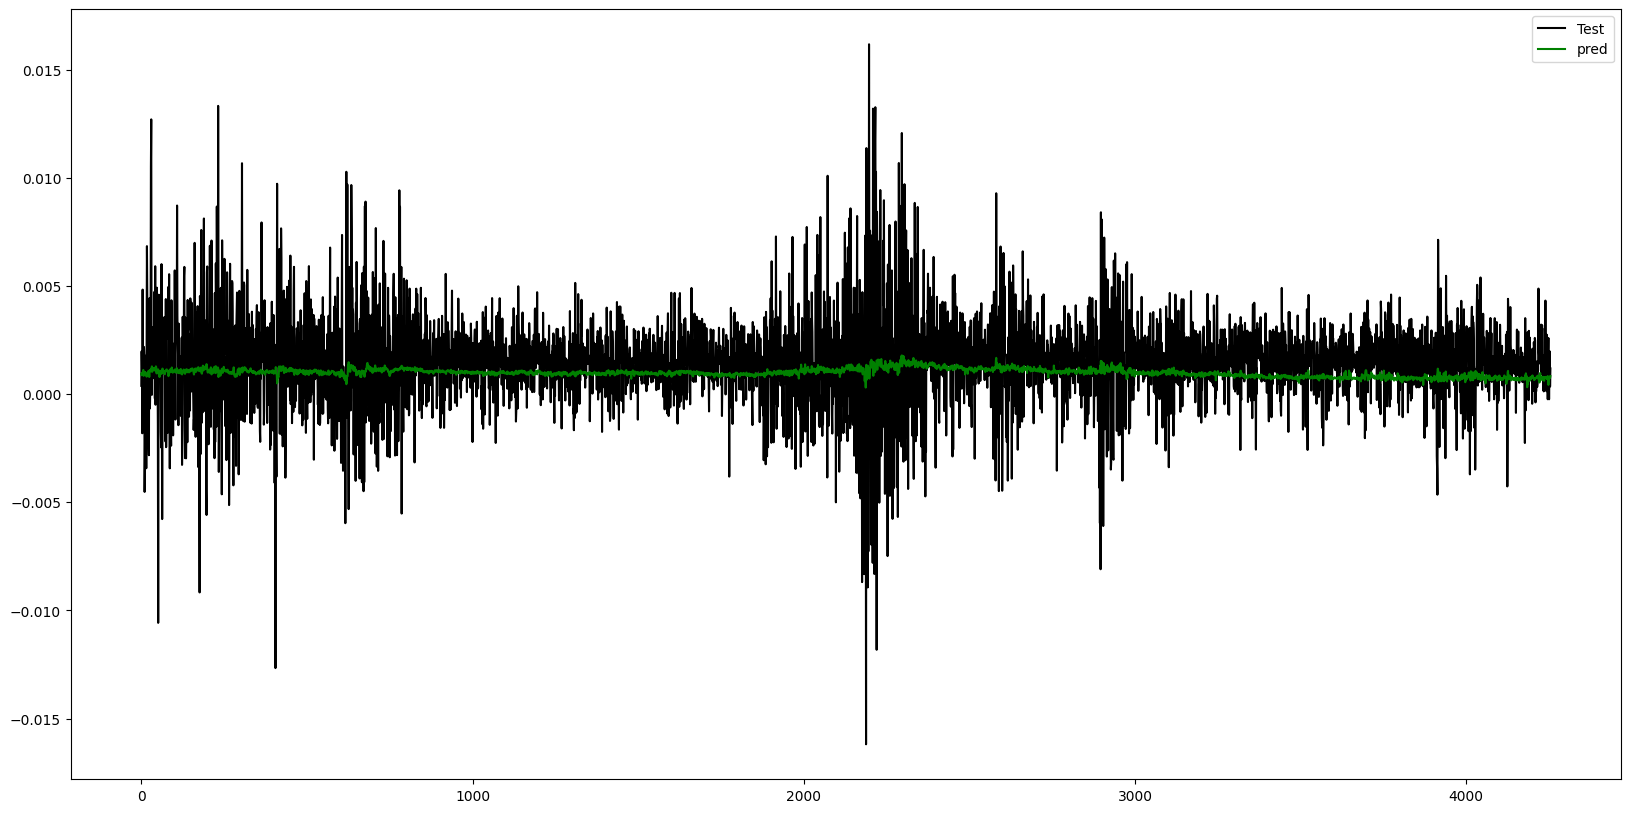

In [269]:
for ticker in ticker_list:
    y_train_AAPL , y_pred_AAPL = print_predictions(model3, X_train_lstm_AAPL,  Y_train_AAPL_scaled, train_AAPL_scaled)
    
plt.figure(figsize=(20,10))
plt.plot(y_train_AAPL, color = 'black', label = 'Test')
plt.plot(y_pred_AAPL, color = 'green', label = 'pred')
plt.legend()
plt.show()

## TEST

8/8 [==============================] - 0s 3ms/step


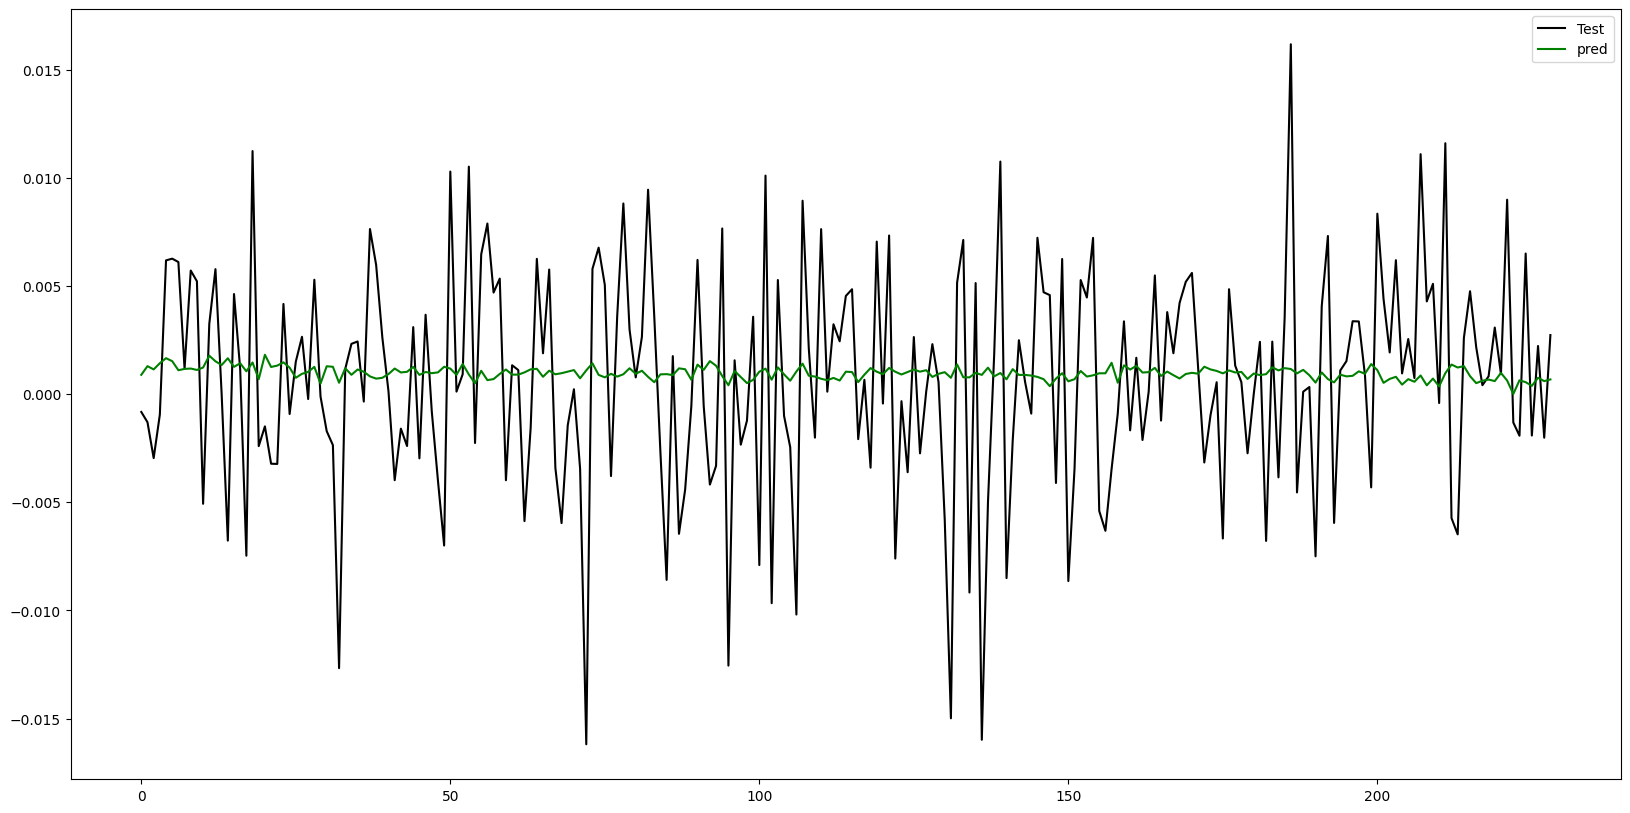

mse: 2.692368867191772e-05
rmse: 0.005188804165886175
mae: 0.004052118759606738
r_square: 0.0014138253249891264


In [270]:
for ticker in ticker_list:
    y_test_AAPL , y_pred_AAPL = print_predictions(model3, X_test_lstm_AAPL,  Y_test_AAPL_scaled, test_AAPL_scaled)
    
plt.figure(figsize=(20,10))
plt.plot(y_test_AAPL, color = 'black', label = 'Test')
plt.plot(y_pred_AAPL, color = 'green', label = 'pred')
plt.legend()
plt.show()

# calculate MSE 
mse=mean_squared_error(y_test_AAPL, y_pred_AAPL)
# calculate RMSE 
rmse = math.sqrt(mean_squared_error(y_test_AAPL, y_pred_AAPL))
# calculate MAE 
mae = mean_absolute_error(y_test_AAPL, y_pred_AAPL)
# calculate R square
r_square=r2_score(y_test_AAPL, y_pred_AAPL)

print("mse: " + str(mse))
print("rmse: " + str(rmse))
print("mae: " + str(mae))
print("r_square: " + str(r_square))


# Model 4

- Model 4 : Gelu(Gaussian Error Linear Unit)
- Single layer
- Activation - Tanh
- loss - mean_squared_error
- optimizer -'adam'

In [271]:
def create_lstm_model4(X_train, y_train, backcandles=20, batch_size=15, epochs=10):
    np.random.seed(10)
    model = Sequential([
        LSTM(150, input_shape=(backcandles, 19), name='first_layer'),
        Dense(1, name='dense_layer'),
        Activation('gelu', name='output')
    ])
    adam = optimizers.Adam()
    model.compile(optimizer=adam, loss='mean_squared_error')
    history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, validation_split=0.1)
    return model, history


Epoch 1/10
256/256 [==============================] - 3s 9ms/step - loss: 0.0097 - val_loss: 0.0046
Epoch 2/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0055 - val_loss: 0.0035
Epoch 3/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 4/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 5/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 6/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0052 - val_loss: 0.0030
Epoch 7/10
256/256 [==============================] - 2s 9ms/step - loss: 0.0051 - val_loss: 0.0034
Epoch 8/10
256/256 [==============================] - 2s 9ms/step - loss: 0.0052 - val_loss: 0.0064
Epoch 9/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0052 - val_loss: 0.0024
Epoch 10/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0051 - val_loss: 0.0023

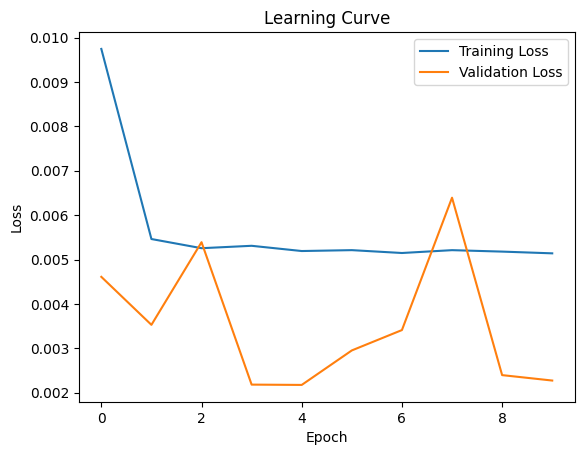

In [272]:
model_and_history = create_lstm_model4(X_train_lstm_AAPL, Y_train_lstm_AAPL)
model4 = model_and_history
history4 = model_and_history[1]
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Train - model4

133/133 [==============================] - 0s 3ms/step


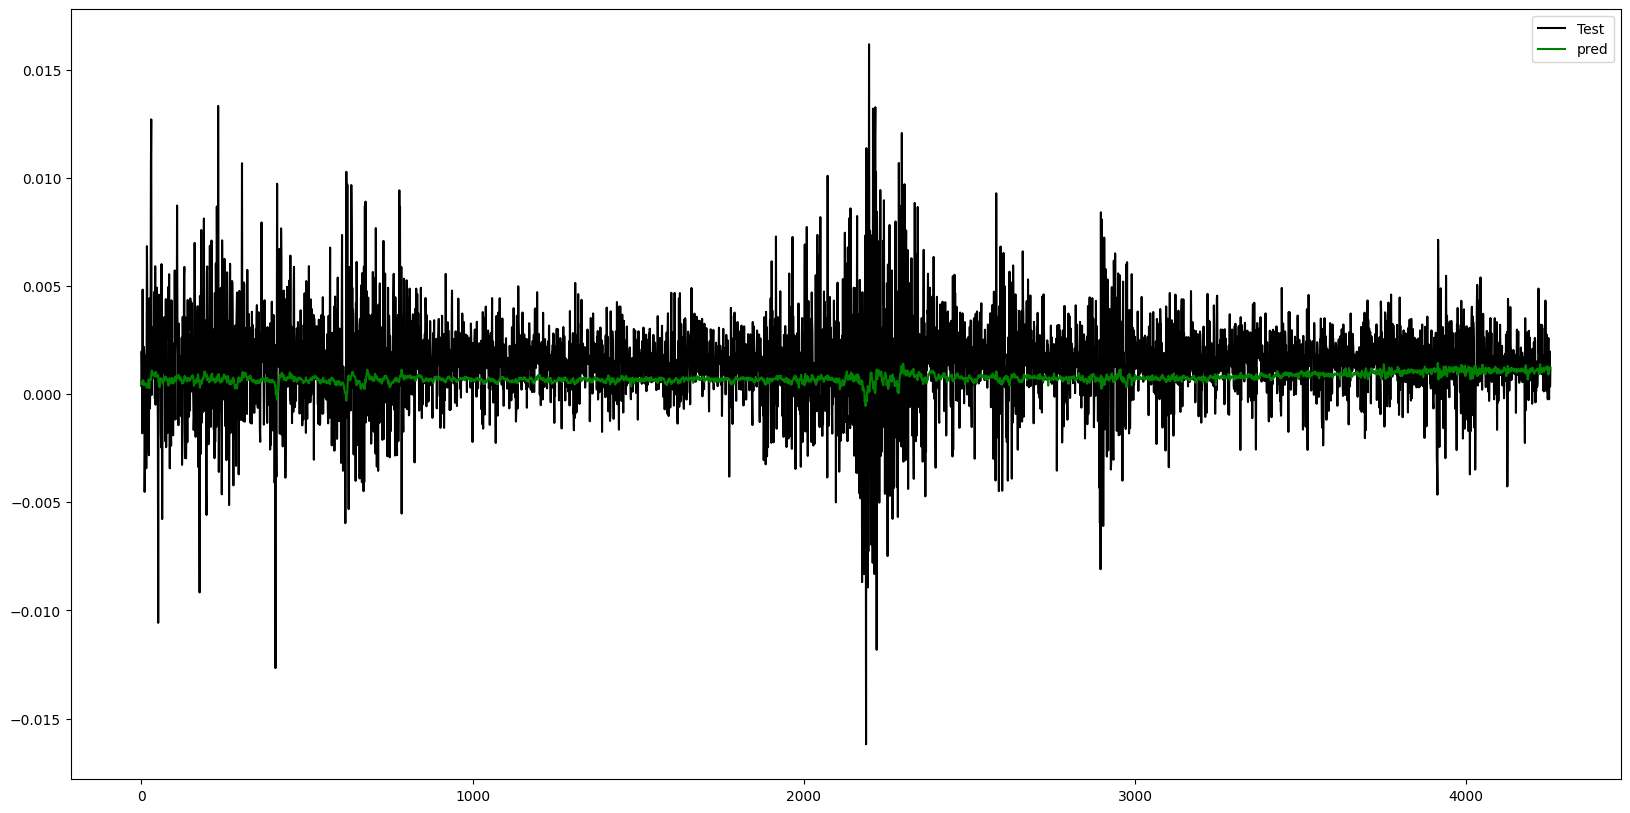

In [273]:
for ticker in ticker_list:
    y_train_AAPL , y_pred_AAPL = print_predictions(model4, X_train_lstm_AAPL,  Y_train_AAPL_scaled, train_AAPL_scaled)
    
plt.figure(figsize=(20,10))
plt.plot(y_train_AAPL, color = 'black', label = 'Test')
plt.plot(y_pred_AAPL, color = 'green', label = 'pred')
plt.legend()
plt.show()

## Test - model4

8/8 [==============================] - 0s 3ms/step


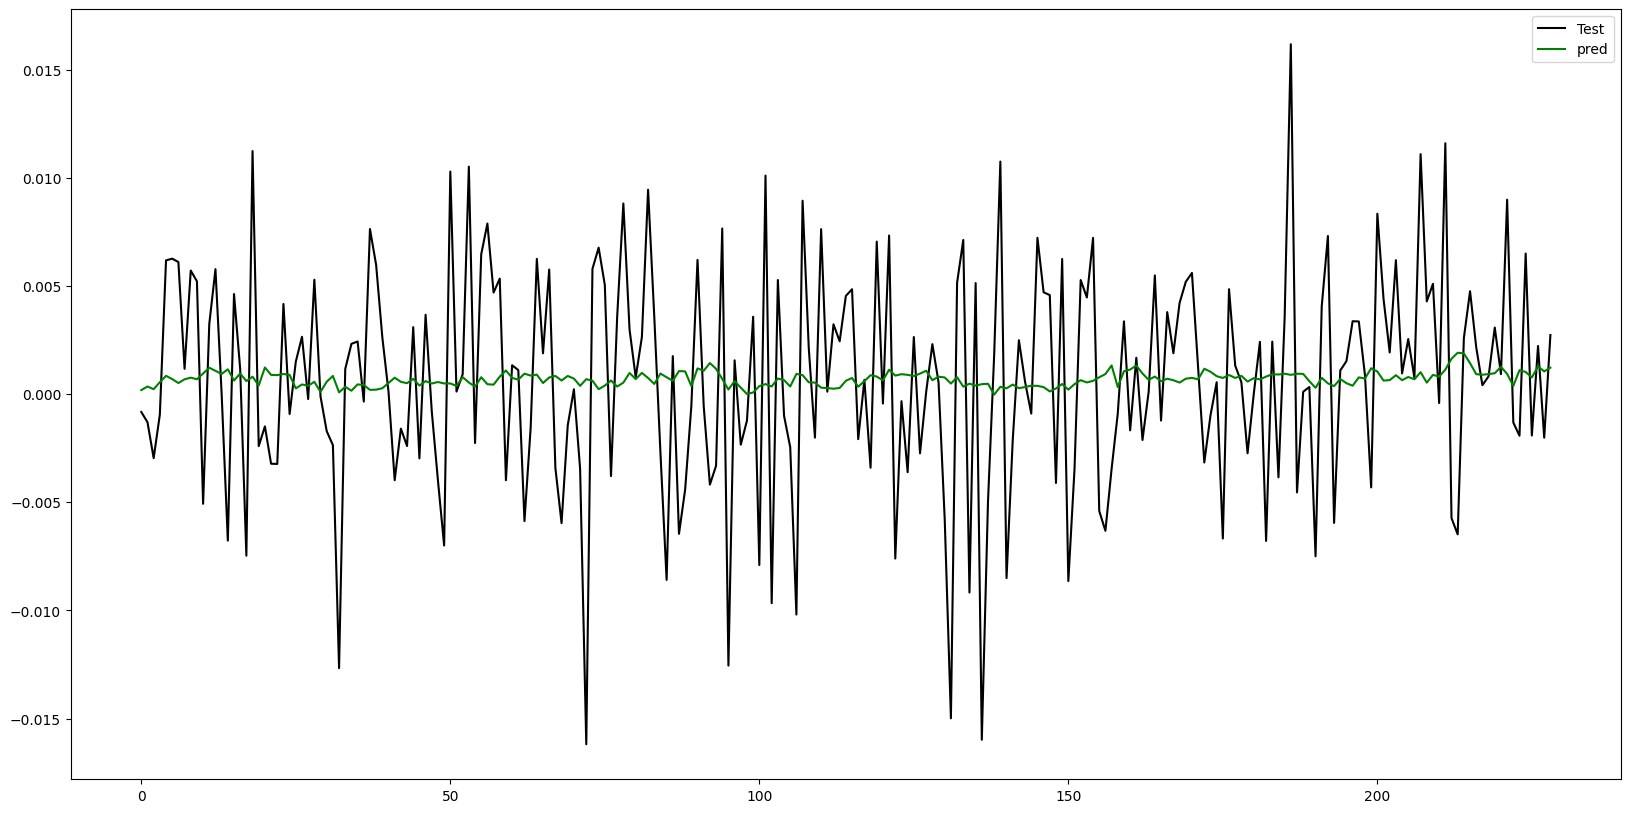

mse: 2.7035549976537955e-05
rmse: 0.005199572095522665
mae: 0.004067626246287986
r_square: -0.002735054631099132


In [274]:
for ticker in ticker_list:
    y_test_AAPL , y_pred_AAPL = print_predictions(model4, X_test_lstm_AAPL,  Y_test_AAPL_scaled, test_AAPL_scaled)
    
plt.figure(figsize=(20,10))
plt.plot(y_test_AAPL, color = 'black', label = 'Test')
plt.plot(y_pred_AAPL, color = 'green', label = 'pred')
plt.legend()
plt.show()

# calculate MSE 
mse=mean_squared_error(y_test_AAPL, y_pred_AAPL)
# calculate RMSE 
rmse = math.sqrt(mean_squared_error(y_test_AAPL, y_pred_AAPL))
# calculate MAE 
mae = mean_absolute_error(y_test_AAPL, y_pred_AAPL)
# calculate R square
r_square=r2_score(y_test_AAPL, y_pred_AAPL)

print("mse: " + str(mse))
print("rmse: " + str(rmse))
print("mae: " + str(mae))
print("r_square: " + str(r_square))


# Model 5 - final model

we will try to add more layers to our LSTM model. Adding multiple layers to a RNN (Recurrent Neural Network) allows the model to learn more complex patterns in the input data. Each layer extracts higher level features from the output of the previous layer. This can help the model to better capture the temporal dependencies in the data, which is important for tasks such as time series forecasting.

optimser - rmsprop

In [275]:
def create_lstm_model5(X_train, y_train, backcandles=20, batch_size=15, epochs=10):
    np.random.seed(10)
    model = Sequential()
    model.add(LSTM(units=8, return_sequences=True, activation="relu",
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=8, return_sequences=True, activation="relu"))
    model.add(Dropout(0.2))
    model.add(LSTM(units=8, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation="tanh"))
    model.compile(optimizer="rmsprop", loss="mean_squared_error")
    history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, shuffle=True, validation_split=0.1)
    return model, history


Epoch 1/10
256/256 [==============================] - 4s 8ms/step - loss: 0.0437 - val_loss: 0.0040
Epoch 2/10
256/256 [==============================] - 2s 7ms/step - loss: 0.0105 - val_loss: 0.0031
Epoch 3/10
256/256 [==============================] - 2s 7ms/step - loss: 0.0069 - val_loss: 0.0022
Epoch 4/10
256/256 [==============================] - 2s 7ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 5/10
256/256 [==============================] - 2s 7ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 6/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 7/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 8/10
256/256 [==============================] - 2s 7ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 9/10
256/256 [==============================] - 2s 7ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 10/10
256/256 [==============================] - 2s 8ms/step - loss: 0.0048 - val_loss: 0.0021

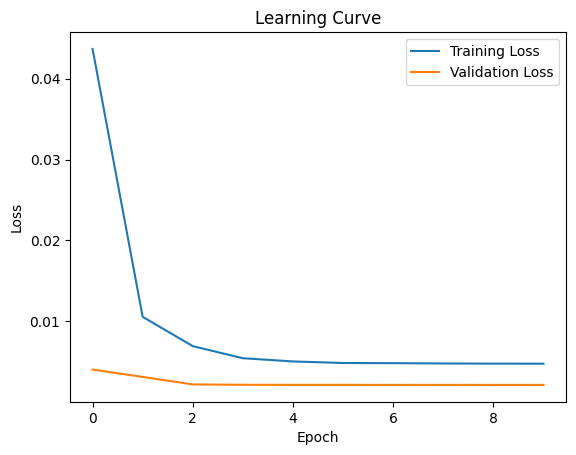

In [286]:
model_and_history = create_lstm_model5(X_train_lstm_AAPL, Y_train_lstm_AAPL)
final_model = model_and_history[0]
history_final = model_and_history[1]
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Train - final model

133/133 [==============================] - 0s 2ms/step


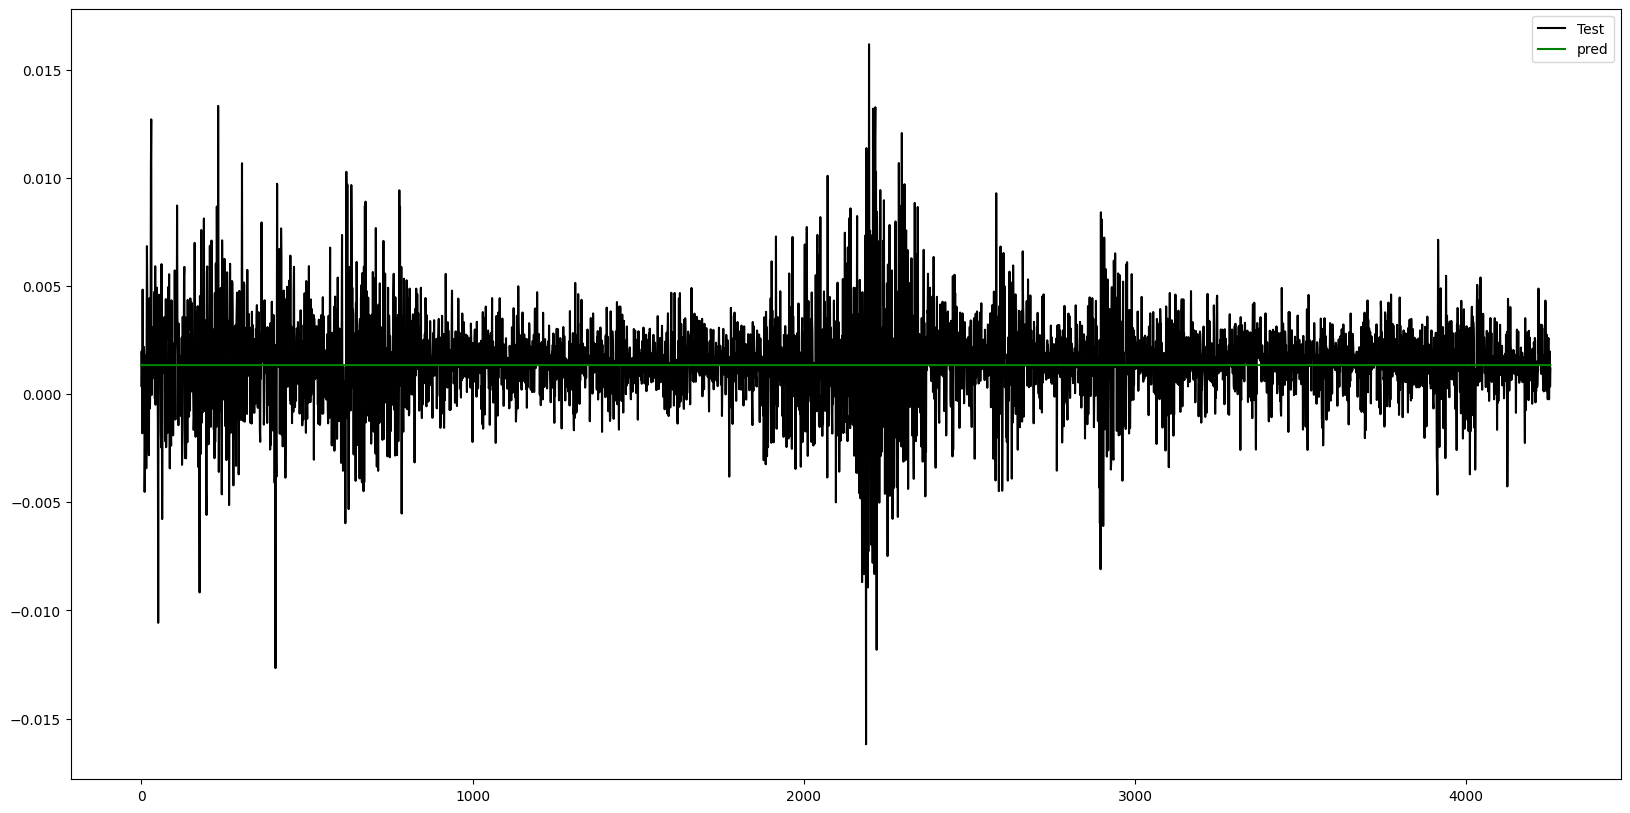

In [277]:
for ticker in ticker_list:
    y_train_AAPL , y_pred_AAPL = print_predictions(final_model, X_train_lstm_AAPL,  Y_train_AAPL_scaled, train_AAPL_scaled)
    
plt.figure(figsize=(20,10))
plt.plot(y_train_AAPL, color = 'black', label = 'Test')
plt.plot(y_pred_AAPL, color = 'green', label = 'pred')
plt.legend()
plt.show()

## Test final model

8/8 [==============================] - 0s 2ms/step


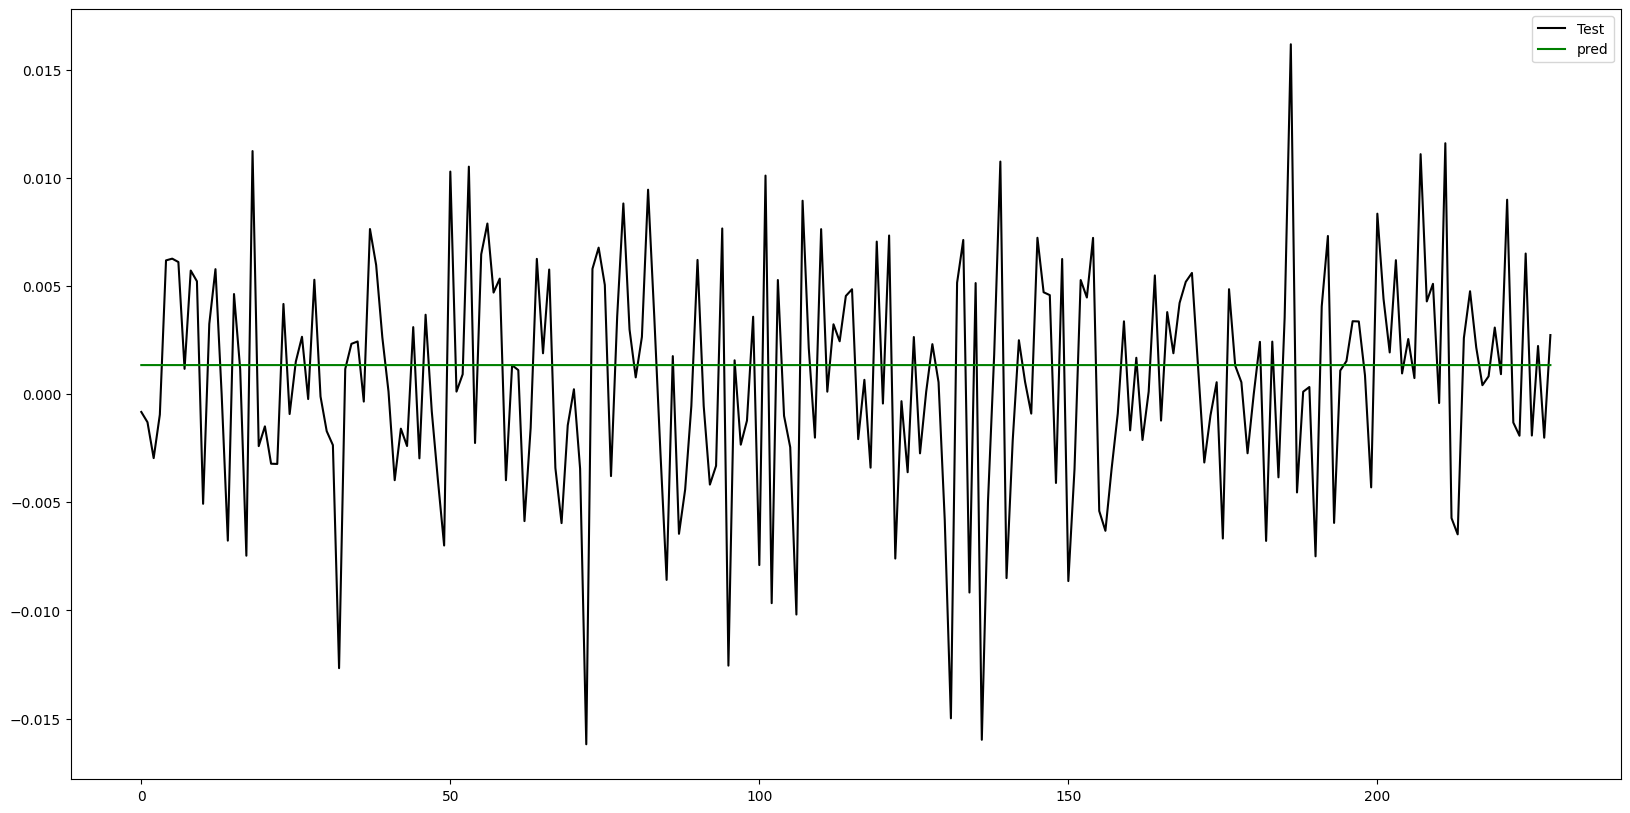

mse: 2.7360812917127702e-05
rmse: 0.005230756438329709
mae: 0.0040721758323801465
r_square: -0.014798894752153346


In [278]:
for ticker in ticker_list:
    y_test_AAPL , y_pred_AAPL = print_predictions(final_model, X_test_lstm_AAPL,  Y_test_AAPL_scaled, test_AAPL_scaled)
    
plt.figure(figsize=(20,10))
plt.plot(y_test_AAPL, color = 'black', label = 'Test')
plt.plot(y_pred_AAPL, color = 'green', label = 'pred')
plt.legend()
plt.show()

# calculate MSE 
mse=mean_squared_error(y_test_AAPL, y_pred_AAPL)
# calculate RMSE 
rmse = math.sqrt(mean_squared_error(y_test_AAPL, y_pred_AAPL))
# calculate MAE 
mae = mean_absolute_error(y_test_AAPL, y_pred_AAPL)
# calculate R square
r_square=r2_score(y_test_AAPL, y_pred_AAPL)

print("mse: " + str(mse))
print("rmse: " + str(rmse))
print("mae: " + str(mae))
print("r_square: " + str(r_square))


# 4. Error analysis and Prediction 

## Evaluate your model on the holdout data directory

**You must run the following cell** from the directory that contains your model file

Here is how we will evaluate your submission
- we will create a directory whose only content is
    - sub-directory `Data`
- we will copy your model file to this directory with the name stored in `model_path`
- we will run the cell in your notebook that should be a copy of the one below
    - it calls procedure `MyModel` with the arguments given below
    - your implementation of `MyModel`
        - must successfully load your model file, *given where **we** have place it as described above*
        - must successfully return one prediction for each example in the holdout directory *given where **we** have placed the holdout directory*

In [293]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path): 
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))
        
    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))
    
    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))
    
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))
    
    return model

def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    
    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []
    
    # YOUR CODE GOES HERE

    for ticker in ticker_list:
        # add indicators
        exec(f'test_data_{ticker} = add_indicators("sample",test_dir+"/" + ticker + ".csv")')


        # scaled data 
        exec(f'train_{ticker}_scaled, X_test_{ticker}_scaled, Y_test_{ticker}_scaled = scale_data(test_data_{ticker})')

        #convert for lstm input 
        exec(f'X_test_lstm_{ticker}, Y_test_lstm_{ticker} = prepare_lstm_data(X_test_{ticker}_scaled, Y_test_{ticker}_scaled)')

        exec(f'y_test_{ticker} , y_pred_{ticker} = print_predictions(model4, X_test_lstm_{ticker},  Y_test_{ticker}_scaled, test_{ticker}_scaled)')

        plt.figure(figsize=(20,10))
        plt.plot(y_test_AAPL, color = 'black', label = 'Test')
        plt.plot(y_pred_AAPL, color = 'green', label = 'pred')
        plt.legend()
        plt.show()

        # calculate MSE 
        mse=mean_squared_error(y_test_AAPL, y_pred_AAPL)
        # calculate RMSE 
        rmse = math.sqrt(mean_squared_error(y_test_AAPL, y_pred_AAPL))
        # calculate MAE 
        mae = mean_absolute_error(y_test_AAPL, y_pred_AAPL)
        # calculate R square
        r_square=r2_score(y_test_AAPL, y_pred_AAPL)

        print("mse: " + str(mse))
        print("rmse: " + str(rmse))
        print("mae: " + str(mae))
        print("r_square: " + str(r_square))

        exec(f'predictions = y_pred_{ticker}')
        exec(f'ids = list(range(len(y_pred_{ticker})))')
        
        return predictions, ids


# Assign to variable my_model the model that is your final model (the one  you will be evaluated on)
my_model = final_model # CHANGE None to your model !

saveModel(my_model, model_path)

Directory ./final_model already exists, files will be over-written.
Model saved in directory ./final_model; create an archive of this directory and submit with your assignment.


8/8 [==============================] - 0s 3ms/step


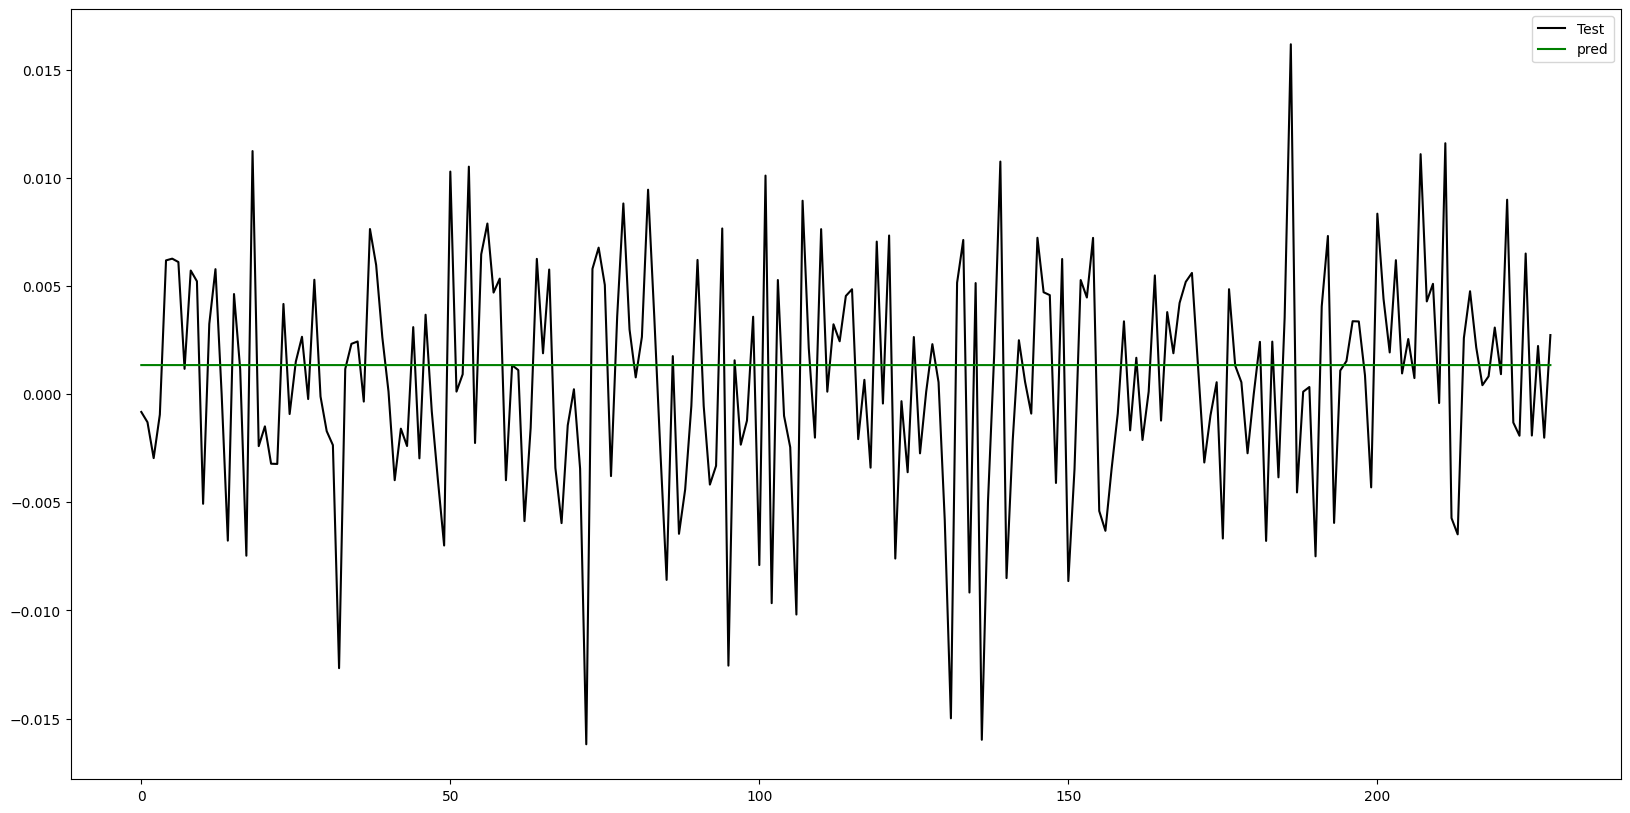

mse: 2.7360812917127702e-05
rmse: 0.005230756438329709
mae: 0.0040721758323801465
r_square: -0.014798894752153346


In [294]:
holdout_dir = os.path.join(".", "Data", "sample")
predictions, ids = MyModel(holdout_dir, model_path)


In [295]:
print("Done")

Done
